## Импорт библиотек

In [204]:
# Бибилиотеки для работы с данными
# ==============================================================================
import pandas as pd
import numpy as np
import os
import graphviz

# Игнорирует все предупреждения
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Визуализация
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Метрики для оценки работы модели
# ==============================================================================
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Разделение данных, кросс валидация и подбор гиперпараметров
# ==============================================================================
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Процессинг данных
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Модели машинного обучения
# =============================================================================
import statsmodels.api as sm # Для построения линейной регрессии
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import catboost
from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv
import xgboost 
from xgboost import XGBRegressor
from xgboost import plot_importance

# Tracking MLFLow
# =============================================================================
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import mlflow.pyfunc

## Настройка параметров графика

In [2]:
# Настройка параметров графика
# ==============================================================================
params = {'figure.figsize' : (12,8),
          'axes.titlesize' : 16,
          'axes.titleweight' : 'bold'}

# Обновление параметров для графиков 
# ==============================================================================
plt.rcParams.update(params)

### Функция для подсчета метрик модели

In [3]:
def metric(model, X, y):
    
    """
    model: модель, для которой вычисляется метрики
    X: Предикторы 
    y: Целевая переменная 
    """
    # Список для записи полученных метрик
    metric_res = []
    
    # Обозначаем метрики которые будем контролировать
    mape = make_scorer(mean_absolute_percentage_error)
    mae = make_scorer(mean_absolute_error)
    mse = make_scorer(mean_squared_error)
    
    # Считаем метрики с использованием 3 фолдов на крос валидации
    mape_cv = cross_val_score(model, X, y, cv = 3, scoring = mape)
    mae_cv = cross_val_score(model, X, y, cv = 3, scoring = mae)
    mse_cv = cross_val_score(model, X, y, cv = 3, scoring = mse)

    # Записываем полученные метрики в список 
    metric_res.append(mape_cv)
    metric_res.append(mae_cv)
    metric_res.append(mse_cv)

    # Получение метрик:
    """
    metric(model, X, y)[0] - mape,
    metric(model, X, y)[1] - mae,
    metric(model, X, y)[2] - mse
    """
    
    return metric_res

### Функция для сохранения данных модели в определенную папку

In [4]:
def save_data(data, folder_name, file_name):
    """
    data: Данные которые будем сохранять
    folder_name: имя папки в которую будем сохранять
    file_name: имя файла который будем сохранять
    """

    file_path = os.path.join(folder_name, file_name)
    data.to_csv(file_path, index=False)

### Функция для сохранения фигуры в определенную папку

In [5]:
def save_fig(folder_name, file_name):
    """
    folder_name: имя папки в которую будем сохранять
    file_name: имя файла который будем сохранять
    """
    
    file_path = os.path.join(folder_name, file_name)

    return file_path

## Просмотр данных 

Загружаем набор данных который мы преобразовали (поработали с пропусками и с типами данных) о ценах на недвижимость в москве и московской области

In [6]:
df = pd.read_csv('Цены на недвижимость без пропусков.csv')
df.head(3)

,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Адрес,Количество комнат,Площадь,Жилая площадь,Кухня площадь,Этаж,Количество этажей,Ремонт,Ссылка
0,6300000.0,Вторичное,Опалиха,6.0,Московская область,Московская Красногорский район Красногорск Изу...,1.0,30.6,11.1,8.5,25.0,25,Косметический,https://www.cian.ru/sale/flat/289238903
1,9000000.0,Вторичное,Павшино,2.0,Московская область,Московская Красногорский район Красногорск Иль...,1.0,49.2,20.0,10.0,6.0,15,Евроремонт,https://www.cian.ru/sale/flat/292849723
2,11090000.0,Вторичное,Мякинино,14.0,Московская область,Московская Красногорский район Красногорск бул...,1.0,44.7,16.2,13.1,10.0,25,Косметический,https://www.cian.ru/sale/flat/290714580


Посмотрим информацию о признаках, чтобы понять с какими мы столбцами будем работать, какие типы данных существуют в нашем наборе данных, сколько уникальных значений (это нам поможет поноять как кодировать категориальные признаки в дальнейшем, при подготовке данных к моделе предсказания), посомтрим количество данных, которое у нас есть, а так же процент непропущенных значений (но так как мы заполнили все значения `NaN`, то в данных не должно быть значений `NaN`

Так же создадим функцию, которая окрашивает категориальные данные в синий цвет, а тип данных число - в красный цвет (это сделано для удобства восприятия)

In [7]:
# Функция для стилизации ячеек
def color_cells(val):
    """ val: значение признака """
    
    if val == 'float64':
        color = 'red'   # цвет для float
    elif val == 'int64':
        color = 'red' # цвет для int
    else:
        color = 'blue' # цвет для object
    return f'color: {color}'

In [8]:
info = pd.DataFrame()
info.index = df.columns
info['Тип данных'] = df.dtypes
info['Колчесвто уникальных'] = df.nunique()
info['Количество пропусков'] = df.isna().sum()
info['Количество значений'] = df.count()
info['%значений'] = round((df.count()/ df.shape[0]) * 100,2)

# Применение стилизации только к столбцу Тип данных
info = info.style.applymap(color_cells, subset=['Тип данных'])

# Информация о признаках (столбцах)
# ==============================================================================
info

,Тип данных,Колчесвто уникальных,Количество пропусков,Количество значений,%значений
Цена,float64,9979,0,22676,100.000000
Тип квартиры,object,2,0,22676,100.000000
Станция метро,object,547,0,22676,100.000000
Минут до метро,float64,56,0,22676,100.000000
Регион,object,2,0,22676,100.000000
Адрес,object,6386,0,22676,100.000000
Количество комнат,float64,12,0,22676,100.000000
Площадь,float64,3017,0,22676,100.000000
Жилая площадь,float64,1302,0,22676,100.000000
Кухня площадь,float64,481,0,22676,100.000000


**Проанализировав данную сводную таблицу сделаем несколько выводов про набор данных:**

1. Мы имеем данное соотношение типо данных - `8 numbers` / `6 objects`, то есть в нашем наборе преобладают числовые значения.
2. Количество значений = 22676 и в каждом признаке 100% заполненных значений
3. Нет пропусков (значений `NaN` в наборе данных)
4. Признак `Цена` очень вариативный, так как содержит 9979 уникальных значений (так же обратно можно сделать вывод, что есть цены на квартиры, которые повторяются)
5. Уникальных значений в столбце `Ссылка` - 21813, а ссылки на дома - это уникальные значения. Следовательно стоит обратить внимание, что есть повторяющиеся ссылки, а следовательно повторяющиеся объявления в данных (дубликаты), которые надо удалить до работы с данными
6. Количество уникальных значений в столбце `Станция метро` надо исследовать и если есть дубликаты преобразовать все к одому виду

Следовательно далььше мы и сделаем удаление дубликатов по столбцу `Ссылка` 
После удаления дубликатов, у нас должен остаться набор, с количеством наблюдений = 21813

### Работа со столбцом Станция метро

In [11]:
# Убираем лишние пробелы и все названия станция делаем с маленьков буквы
df['Станция метро'] = df['Станция метро'].str.lower().str.strip()

In [12]:
df['Станция метро'].nunique()

310

Количество уникальных занчений в данном столбце уменьшилось -> были дубликаты в данных, которые мы преобразовали.

Новые значения сохранены с основной набор данных

In [13]:
# Удаление дубликатов по столбцу Сслыка
df = df.drop_duplicates(subset="Ссылка")

# Проверка (размер = 21813) и вывод набора дыннх
print(df.shape)
df.head(3)

(21813, 14)


,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Адрес,Количество комнат,Площадь,Жилая площадь,Кухня площадь,Этаж,Количество этажей,Ремонт,Ссылка
0,6300000.0,Вторичное,опалиха,6.0,Московская область,Московская Красногорский район Красногорск Изу...,1.0,30.6,11.1,8.5,25.0,25,Косметический,https://www.cian.ru/sale/flat/289238903
1,9000000.0,Вторичное,павшино,2.0,Московская область,Московская Красногорский район Красногорск Иль...,1.0,49.2,20.0,10.0,6.0,15,Евроремонт,https://www.cian.ru/sale/flat/292849723
2,11090000.0,Вторичное,мякинино,14.0,Московская область,Московская Красногорский район Красногорск бул...,1.0,44.7,16.2,13.1,10.0,25,Косметический,https://www.cian.ru/sale/flat/290714580


После преобразования мы проверили размер и размер сошелся, следовательно мы удалили все дубликаты в данных.

Далее построим новую таблицу для просмотра описательной статистики

**Выводы описательной статистики:**
1. Срденее значение цены квартиры 32 878 966.67
2. Минимальная цена дома 1 150 000
3. Максимальная цена дома 2 455 020 000
4. Между 75% и максимальным значением цены - очень большой диапазон знчений, что свидетельствует о наличии аномальных значений
5. Так же на это указывает значение std, которое равно 77 996 296.24, что означает очень большой разброс значений вокруг среднего
6. Так же есть аномальные значения в признаках `Минут дло метро`, `Количество комнат`, `Жилая площадь` и все остальные числовые признаки в модели

Данные аномалии не являются ошибками в данных, это просто значения дорогих квартир, для того чтобы принять решение о том, что делать с аномальными значениями - проведем дальнейший анализ

In [14]:
describe = df.describe().T
describe['mean'] = describe['mean'].apply(lambda x: '{:.2f}'.format(x))
describe['std'] = describe['std'].apply(lambda x: '{:.2f}'.format(x))
describe['max'] = describe['max'].apply(lambda x: '{:.2f}'.format(x))
describe['count'] =describe['count'].astype('int')

# Описательная статистика для набора данных
# ==============================================================================
describe

,count,mean,std,min,25%,50%,75%,max
Цена,21813,32878966.67,77996296.24,1150000.0,6998445.00,11086692.0,22383687.00,2455020000.00
Минут до метро,21813,11.98,6.21,0.0,7.00,12.0,15.00,60.00
Количество комнат,21813,2.01,1.47,0.0,1.00,2.0,3.00,12.00
Площадь,21813,68.76,62.99,6.0,37.16,52.4,74.65,1117.00
Жилая площадь,21813,37.00,35.31,2.0,17.50,28.1,42.00,566.80
Кухня площадь,21813,12.34,7.39,1.0,8.60,10.5,14.00,122.00
Этаж,21813,9.17,7.40,1.0,4.00,8.0,13.00,92.00
Количество этажей,21813,16.51,9.42,1.0,11.00,16.0,20.00,97.00


Для визуализации мы построим матрицу графиков для признака `Цена`, чтобы посмотреть распредление и структуру данных в признаке 

**Выводы по визуализации:**
1. Как и в описательной статистике, видно что большинство значний расположено в белой зоне
2. Небольшая площадь белой зоны указывает что значения цены распределены преимущественно на небольшом диапазоне
3. Красная зона (она визуализирована в значении матрицы 2,2 - 2 строка, 2 график). Там показано распредление количества квартир с определенными ценами, то есть сделан Zoom на график.
4. По графику `Распределение непопулярных значений` можно сделать вывод, что чем дороже квартира, тем меньше их в наборе данных)
5. Так же график `Диаграмма ящика` показывает нам на то, что в данных есть выбросы и их количество

Все эти графики отражают структуру целевого признака `Цена`, для которого мы будем делать предсказание
Здесь построены разные виды графиков, но все они отржают одну суть - просмотр и выявление структуры и аномальных значений в признаке `Цена`

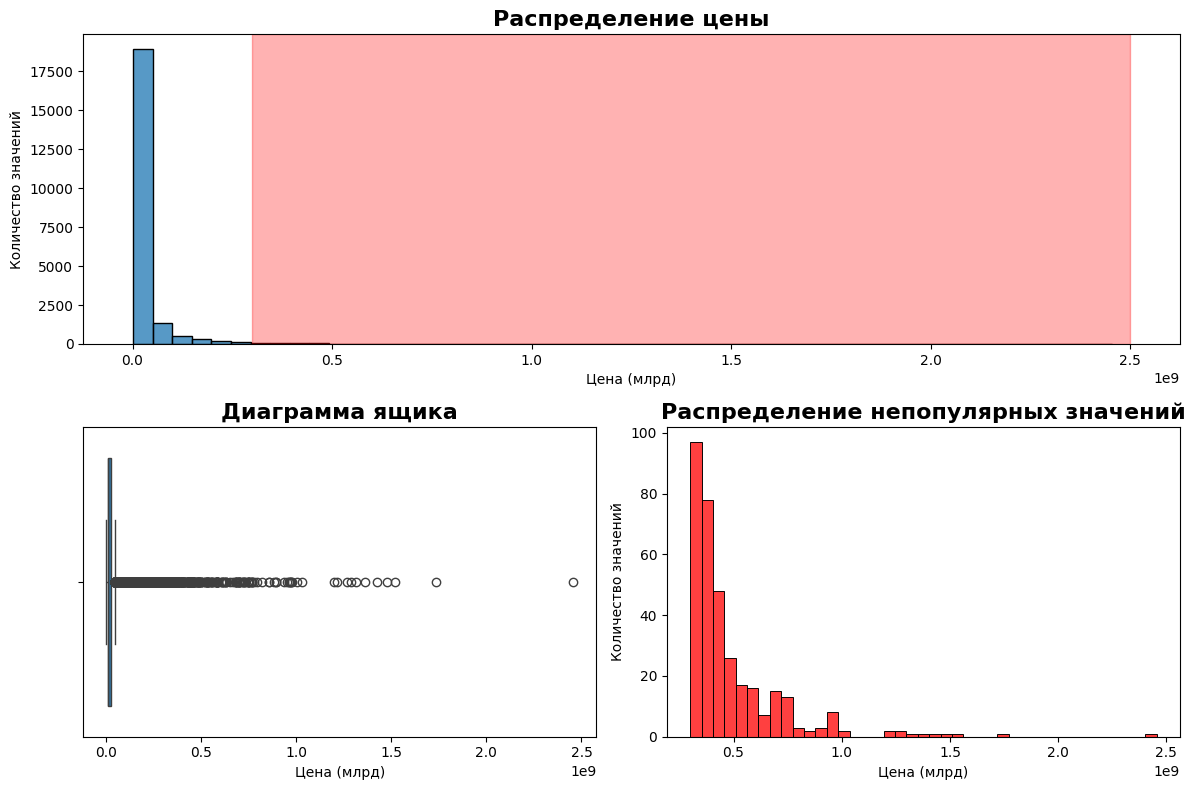

In [15]:
# Первый график - Распределение цены (гистограмма)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan = 2) # 1 значение - размер сетки подграфика, 2 значение - положение подграфика, colspan - растянутость 
sns.histplot(data = df,
             x = 'Цена',
             bins = 50,
             ax = ax1)
# Выделение диапазона от 80 до 100
ax1.axvspan(0.3e9, 2.5e9, color='red', alpha=0.3)
ax1.set_title('Распределение цены')
ax1.set_xlabel('Цена (млрд)')
ax1.set_ylabel('Количество значений')



# Второй график - Диаграмма ящика с усами
ax2 = plt.subplot2grid((2, 2), (1, 0))
sns.boxplot(data = df, x = 'Цена', ax = ax2)
ax2.set_title('Диаграмма ящика')
ax2.set_xlabel('Цена (млрд)')



# третий график - Значения цены, которые больше 300 000000 
unpopular = df[df['Цена'] >= 0.3 * 10**9]
# Визуализация распределения значений > 300 000000
ax3 = plt.subplot2grid((2, 2), (1, 1))
sns.histplot(data = unpopular,
             x = 'Цена',
             ax = ax3,
            color = 'red')
ax3.set_title('Распределение непопулярных значений')
ax3.set_xlabel('Цена (млрд)')
ax3.set_ylabel('Количество значений')

# Комплексная визуализация целевого признака 
# ==============================================================================
plt.tight_layout()
plt.show()

Так же построим такой же график по площади (так как цена и площадь - это ключевые показатели в наборе данных)

**Выводы по визуализации площади и взаимосвязи переменных:**
1. Значения площади (так же как и значения цен на квартиры) распложены преимущественно в диапазоне от 0 до 100
2. Так же можно заметить что есть аномальные значения (то есть площадь квартир, которые больше 100)
3. Взаимосвязь между признаками `Цена` и  `Площадь` = 0.79, то есть медлу признаками существет линейная зависимоть (можно описать формулой)

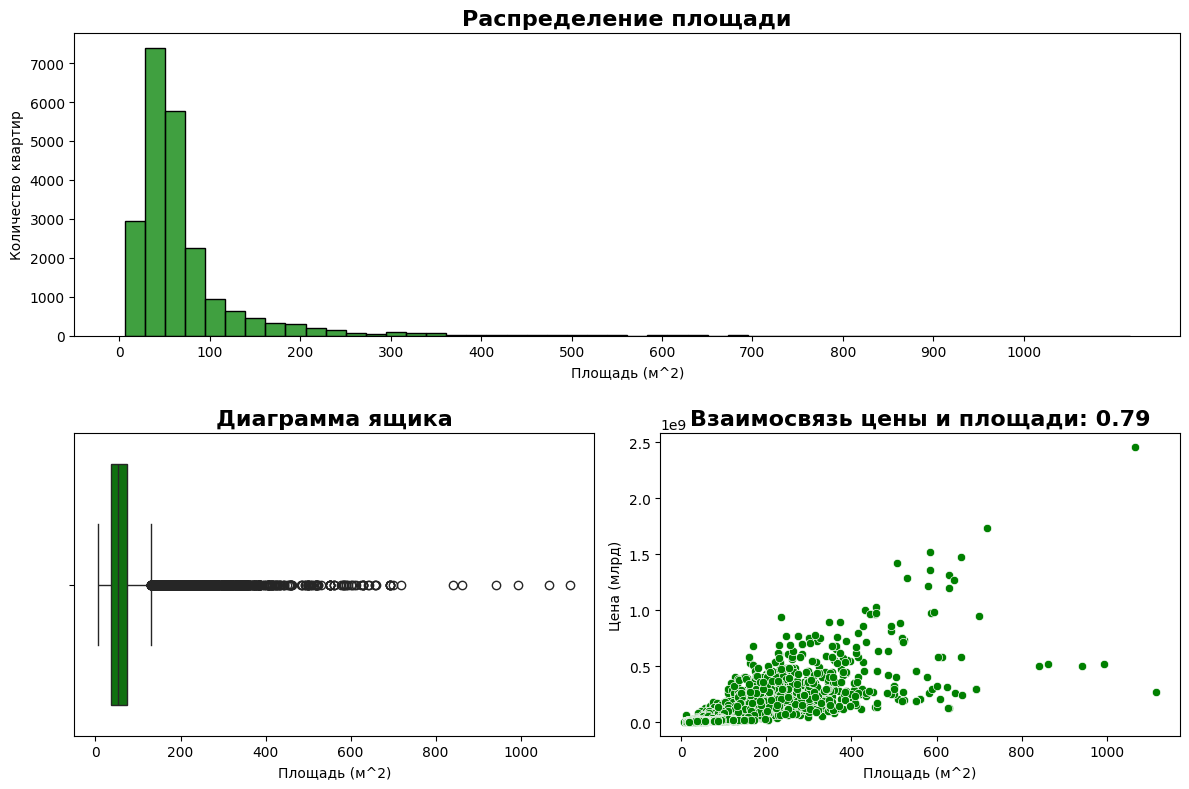

In [16]:
# График 1 - распределение площади
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan = 2) 
sns.histplot(data = df,
             x = 'Площадь',
             bins = 50,
             ax = ax1,
             color = 'g')
ax1.set_title('Распределение площади')
ax1.set_ylabel('Количество квартир')
ax1.set_xlabel('Площадь (м^2)')
ax1.set_xticks(range(0,1001,100))

# График 2 - Диаграмма ящик с усами
ax2 = plt.subplot2grid((2, 2), (1, 0))
sns.boxplot(data = df, x = 'Площадь', ax = ax2, color = 'g')
ax2.set_title('Диаграмма ящика')
ax2.set_xlabel('Площадь (м^2)')

# График 3 - Точечная диаграмма взаимосвязи между ценой и площадью
ax3 = plt.subplot2grid((2, 2), (1, 1))
sns.scatterplot(data = df,
                x = 'Площадь',
                y = 'Цена',
                ax = ax3,
                color = 'g')
# Корреляция между ценой и площадью
corelation = round(df[['Площадь', 'Цена']].corr()['Цена'].loc['Площадь'],2)
ax3.set_title(f'Взаимосвязь цены и площади: {corelation}')
ax3.set_xlabel('Площадь (м^2)')
ax3.set_ylabel('Цена (млрд)')


# Комплексная визуализация признака площадь и взаимосвязь между площадью и целевым значением  
# ==========================================================================================
plt.tight_layout()
plt.show()

После визуализации двх признаков (`Цена` и `Площадь`) и просмотра описательной статистики можно сказать, что так как во всех признаках есть аномальные значени (то есть значения которые выбиваются из большинства значений) то скорее всего все эти аномальные значения как раз и связаны с высокой ценой квартиры

Мы проверим эту гипотизу, чтобы точно ответить на вопрос, правда это или нет

**Что сделали чтобы проверить гипотезу**: Посчитали количество аномальных значений (которые идут после 75%) по каждой переменной

**Выводы по гипотезе**
1. Количество аномальных значений по каждому признаку примерно равно (единственное значение которое выбивается - количество комнат и количество этажей)

Следовательно скорее всего это такая природа данных, то есть аномальные значения - это не ошибки, и пока будем работать с полным набором данных (то есть не будем делать никаких преобразований с выбросами)
После построения моделей машинного обучения поэксперементируем с выбросами и выберем исход, который использовать при выборе финальной модели

In [17]:
#  Набор данных для записи количества аномальных значений
number_extreme = pd.DataFrame()
# Список для передачи в индекс
list_index = []
# Список для передачи значений
list_values = []

for i in describe.index:
    """
    Создается порог (doorstep) для того чтобы создать набор с аномальными значениям (set)
    Внутри определяется описательная статистика (describe) и записывается только признак и количество значений (count) по каждому 
    признаку в цикле (describe.index - все числовые признаки)
    """
    
    doorstep = describe['75%'].loc[i]
    set = df[df[i] > doorstep]
    set = set.describe().T
    list_index.append(i)
    list_values.append(set['count'].loc[i])

number_extreme.index = list_index
number_extreme['Количество экстремальных значений'] = list_values
number_extreme

,Количество экстремальных значений
Цена,5453.0
Минут до метро,5276.0
Количество комнат,3230.0
Площадь,5452.0
Жилая площадь,5428.0
Кухня площадь,5452.0
Этаж,5046.0
Количество этажей,4020.0


Далее визуализируем взаимосвязь между признаками и посмотрим мультиколлинеарность среди числовых признаков

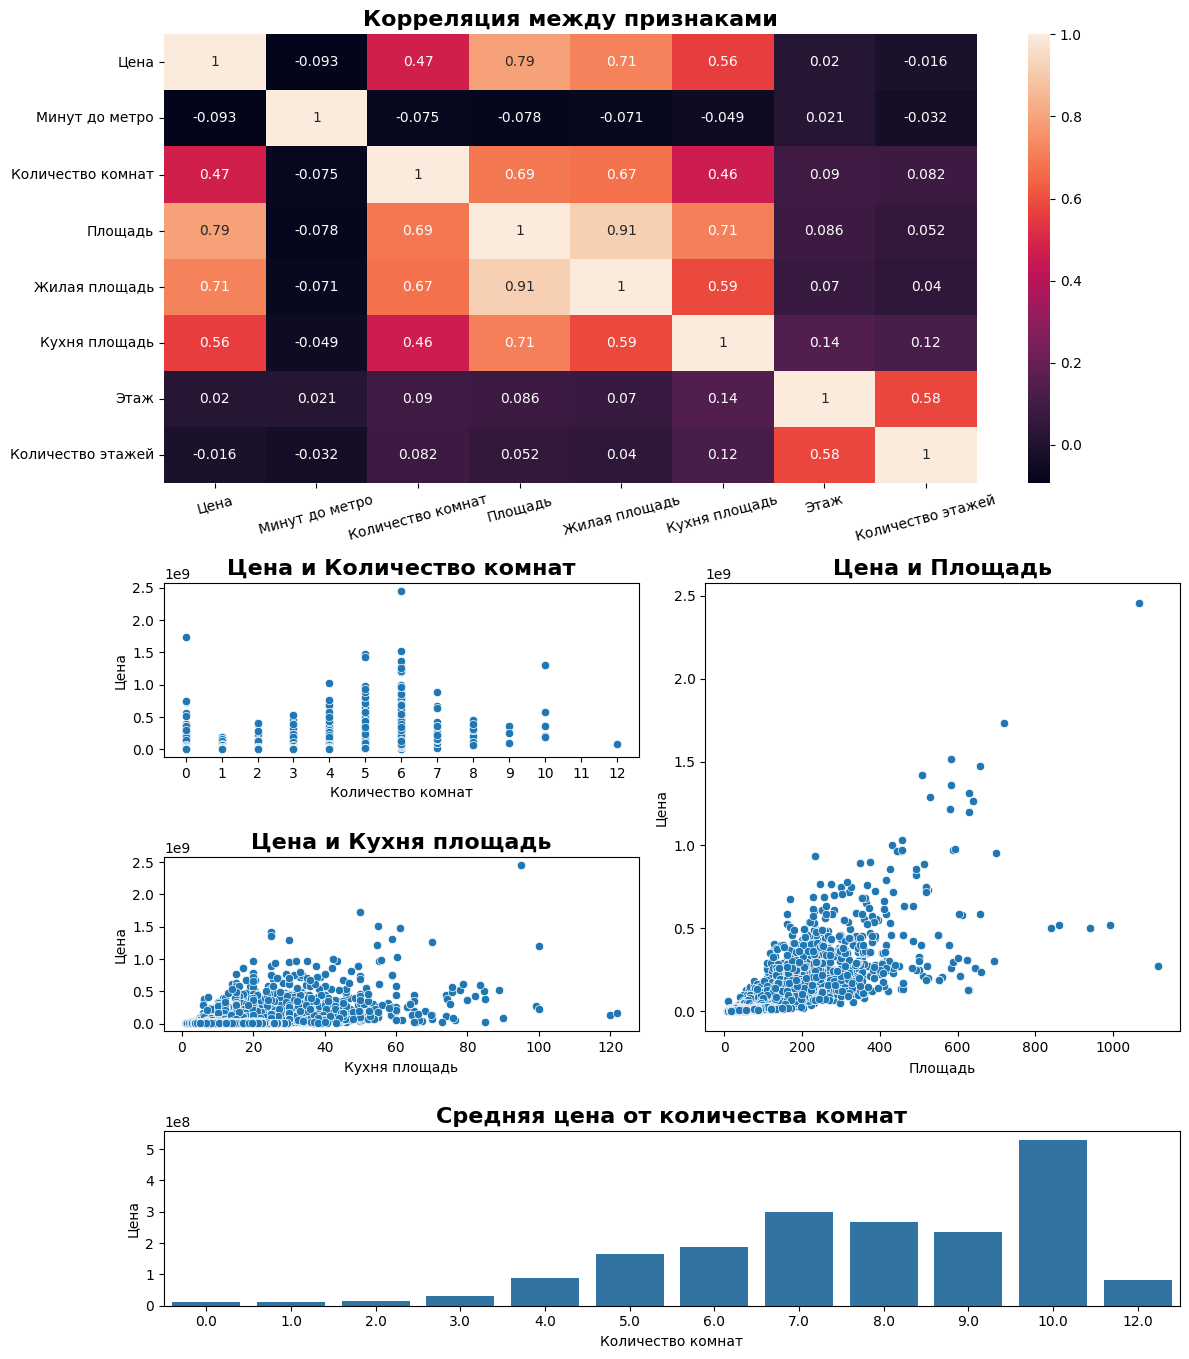

In [18]:
correlation = df.select_dtypes(include = ['float64', 'int64']).corr()

# Настроим размер общего холста (Figure)
fig = plt.figure(figsize=(12, 16))

# График 1 - Матрица корреляции для всех признаков 
ax1 = plt.subplot2grid((6, 2), (0, 0), rowspan = 2, colspan = 2)
sns.heatmap(correlation, annot = True, ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15) # Поворот меток на оси x
ax1.set_title('Корреляция между признаками')


# График 2 - Взаимосвязь между ценой и количеством комнат
ax2 = plt.subplot2grid((6, 2), (2, 0))
sns.scatterplot(data = df,
                x = 'Количество комнат',
                y = 'Цена',
                ax = ax2)
ax2.set_xticks(range(0,13,1))
ax2.set_title('Цена и Количество комнат')


# График 3 - Взаимосвязь между ценой и площадью
ax3 = plt.subplot2grid((6, 2), (2, 1), rowspan = 2)
sns.scatterplot(data = df,
                x = 'Площадь',
                y = 'Цена',
                ax = ax3)
ax3.set_title('Цена и Площадь')


# График 4 - Взаимосвязь между ценой и площадью кухни
ax4 = plt.subplot2grid((6, 2), (3, 0))
sns.scatterplot(data = df,
                x = 'Кухня площадь',
                y = 'Цена',
                ax = ax4)
ax4.set_title('Цена и Кухня площадь')


# График 5 - Средние значения цены в зависимости от количества комнат
ax5 = plt.subplot2grid((6, 2), (4, 0), rowspan = 1, colspan = 2)
price = df.groupby('Количество комнат').agg({'Цена' : 'mean'})
sns.barplot(data = price,
            x = price.index,
            y = price['Цена'],
            ax = ax5)
ax5.set_title('Средняя цена от количества комнат')

# Визуализация взаимосвязи между предикторами и целевой переменной
# ==============================================================================
plt.tight_layout()
plt.show()

**Вывод по визуализации взаимосвязей переменных:**
-
**Матрица корреляции**
1. Существует линейная зависимость между `Цена` (целевая переменная) и следующими признаками:
   -  `Количество комнат`
   -  `Площадь`
   -  `Жилая площадь`
   -  `Кухня площадь`
2. Существует мультиколлинеарность между признаками `Жилая площадь` и `Площадь`
Так как среди данных переменных наблюдается мультиколлинеарность (то есть сильная корреляция между предикторами), то удалим менее значимый признак (у которго меньше корреляция с целевой переменной - в данном случае - `Жилая площадь`
3. Так же сильная корреляция наблюдается между другими признаками
Нарпример `Площадь` - линейно зависима от таких признаков как `Количество комнат` и `Кухня площадь`
Или `Площадь кухни` линейно зависима так же от `Количество комнат`

То есть из этой информации делаем вывод, что чем больше комнат - тем больше площадь квартиры и соответственно тем больше цена квартиры (это только один из выводов, которые можно сделать)

**Точесные диаграммы**
Показывают взаимосвять признаков с целевой переменной (только те признаки, которые сильно коррелируют с целевой переменной `Цена`)
Здесь я построил 3 точечные диаграммы, так как сильная корреляци наблюдается только между целевой переменной и тремя предикторами

**Средняя цена от количества комнат**
График который показывает как количество комнат влияет на срденюю цену квартиры (это также показывает взаимосвязь между признаком `Количество комнат` и `Цена`
1. Цена квартиры растет с увеличением комнат до 7 комнат -> дальше цена падает (на это могут влиять внешние факторы, которые не учитывались при построении модели) -> наибольшая средняя цена за квартиру - 10 комнат -> цена падает на 12 комнатах, так как на это могут влиять так же другие внушние факторы, которые не были учтены

**Вывод**
После просмотра и анализа данной визуализации:
1. Определили признаки, которые взаимосвязаны с целевой переменной  (`Цена`)
2. Определили признак, который надо удалить из за наличия мультиколлинеарности (`Жилая площадь`)
3. Визализировали взаимосвязи между признаками и целемой переменной

Далее удалим признак `Жилая площадь` и просмотрим промежуточный наборы данных

In [19]:
df.drop('Жилая площадь', axis = 1, inplace = True)
print('Размер набора данных: ', df.shape)
df.head(3)

Размер набора данных:  (21813, 13)


,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Адрес,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Ремонт,Ссылка
0,6300000.0,Вторичное,опалиха,6.0,Московская область,Московская Красногорский район Красногорск Изу...,1.0,30.6,8.5,25.0,25,Косметический,https://www.cian.ru/sale/flat/289238903
1,9000000.0,Вторичное,павшино,2.0,Московская область,Московская Красногорский район Красногорск Иль...,1.0,49.2,10.0,6.0,15,Евроремонт,https://www.cian.ru/sale/flat/292849723
2,11090000.0,Вторичное,мякинино,14.0,Московская область,Московская Красногорский район Красногорск бул...,1.0,44.7,13.1,10.0,25,Косметический,https://www.cian.ru/sale/flat/290714580


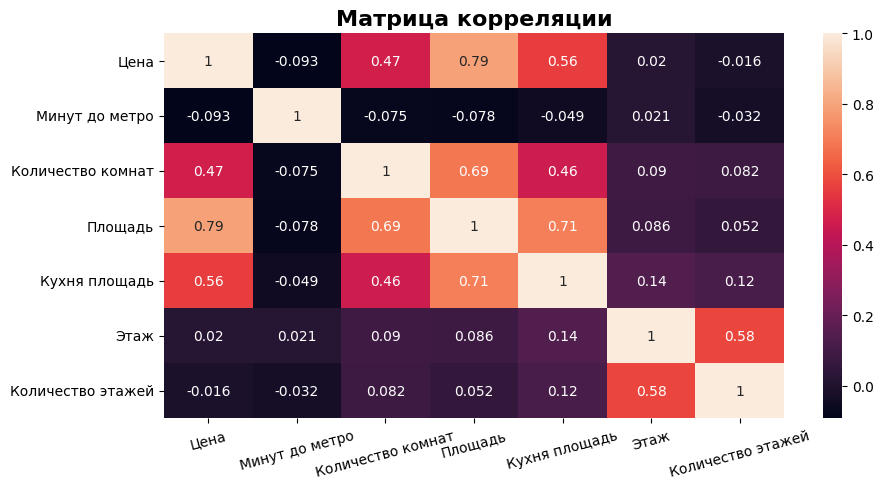

In [20]:
plt.subplots(figsize = (10,5))
correlation = df.select_dtypes(include = ['float64', 'int64']).corr()
sns.heatmap(correlation, annot = True)
plt.title('Матрица корреляции')
plt.xticks(rotation = 15)
plt.show()

## LinearRegression - Модель в MLFlow Tracking

### Ячейки не запускать

В качестве первой модели, построим модель линейной регрессии, которая будет включать в себя такие признаки, как 

`Цена` - целевая переменная 

Объясняющие переменные:
`Количество комнат`, `Площадь` и `Кухня площадь`  

Оценим эту модель на производительность и внесем ее в Tracking моделей в MLFlow для последующего сравнения с другими моделями, которые будут строиться дальше

In [22]:
# Разделеяем набор данных на целевую переменную и предикторы
y = df['Цена']
X = df[['Количество комнат', 'Площадь', 'Кухня площадь']]

# Строим модель линейной регресси на полном наборе данных
X = sm.add_constant(X)
linear_model = sm.OLS(y,X) # Метод наименьших квадратов
result = linear_model.fit() # Тренировка модели

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                 1.272e+04
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:21:01   Log-Likelihood:            -4.1631e+05
No. Observations:               21813   AIC:                         8.326e+05
Df Residuals:                   21809   BIC:                         8.327e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.715e+07   6.86e+0

После построения модели, признак `Кухня площадь` - оказался незначимым, поэтому удалим его и снова построим модель линейной регрессии и оценим результат с помощью модели `LineraRegression` в **sklearn**

In [23]:
y = df['Цена']
# Удалили признак 'Кухня площадь'
X = df[['Количество комнат', 'Площадь']]

# Строим модель линейной регресси на полном наборе данных
X = sm.add_constant(X)
linear_model = sm.OLS(y,X) # Метод наименьших квадратов
result = linear_model.fit() # Тренировка модели

# Вывод рузельтатов тренировки модели линейной регрессии
# ==============================================================================
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                 1.908e+04
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:21:03   Log-Likelihood:            -4.1631e+05
No. Observations:               21813   AIC:                         8.326e+05
Df Residuals:                   21810   BIC:                         8.327e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.783e+07   5.43e+0

In [24]:
params = result.params.to_frame()
params.columns = ['Веса модели']
params['Веса модели'] = params['Веса модели'].apply(lambda x: '{:.2f}'.format(x))

# Вывод параметров (весом) модели линейной регрессии
# ==============================================================================
params

,Веса модели
const,-27825303.75
Количество комнат,-7419286.54
Площадь,1099819.22


После удаления признака, качетсво модели (по критерию R2) никак не ухудшилось, поэтому протестируем модель с помощью sklern

In [25]:
# Раздибаем данные на тестовые и тренировочные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 10)

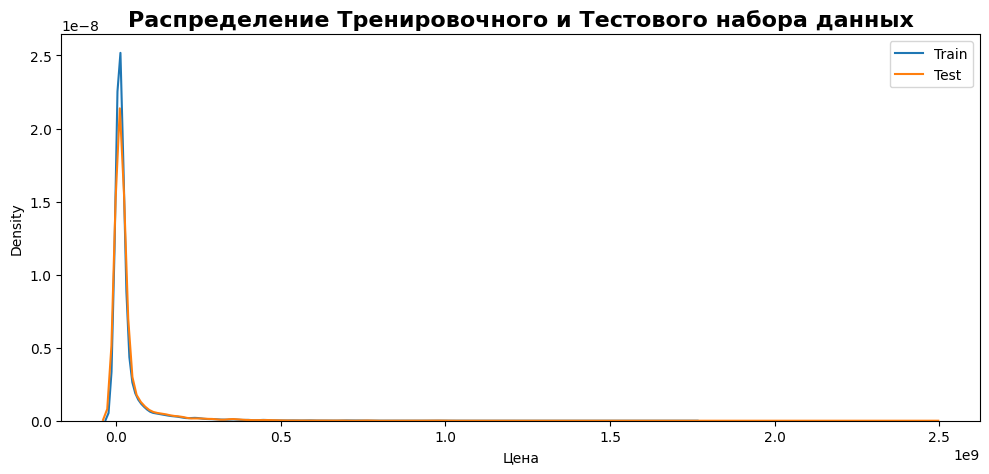

In [26]:
plt.subplots(figsize = (10,5))
# Смотрим распределение тестового и тренировочного набора данных (по цуелевой переменной)
sns.kdeplot(y_train, label = 'Train')
sns.kdeplot(y_test, label = 'Test')

plt.title('Распределение Тренировочного и Тестового набора данных')
plt.legend()
plt.tight_layout()
plt.show()

Данное распределение тренировочного и тестового набора данных выбрано именно это, потому что тренировочный и тестовых набор похожи по количеству информации о ценах, которые они представляют

Что имеется под количеством информации о ценам, на данном график:

То есть плотность значений опеределенной цены в одном наборе данных = плотности этой же цены в другом наборе данных, поэтому можно натренировать модель на данных, а потом протестировать их на похожих данных и оценить производительность модели

In [27]:
# Тренируем модель линейной регрессии 
# ==============================================================================
lr = LinearRegression()
lr.fit(X_train, y_train)

# Предсказание 
# ==============================================================================
y_pred = lr.predict(X_test)

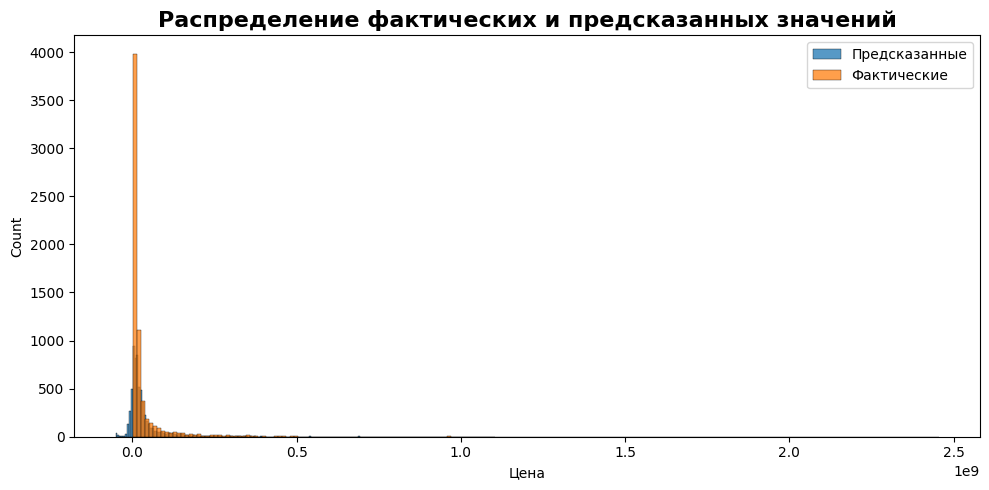

In [28]:
plt.subplots(figsize = (10,5))
sns.histplot(y_pred, bins = 200, label = 'Предсказанные')
sns.histplot(y_test, bins = 200, label = 'Фактические')

plt.title('Распределение фактических и предсказанных значений')
plt.legend()
plt.tight_layout()
plt.savefig(save_fig('figures', 'Распределение факт и пред LR.png'))
plt.show()

Данное распределение между предсказанными значениями и фактическими значениями нужно, чтобы понять как распределяется цена на предсказанных значениях. 

По графику видно, что модель занижает значения цен, и есть значения, которые модель предсказала неправильно, совсем отклонившись от данных (синяя область слева), после мы оценим метрики модели, но уже сейчас можно сделать вывод, что можно протестирорвать вариант с регулязацией модели и попробовать в использовании L2 (Ridge) Регулязацию, после чего так же добавить ее к сравнению моделей

In [29]:
lr = LinearRegression()
# Тренируем на полном наборе данных, чтобы оценить производительность на кросс валидации
lr.fit(X, y)

LinearRegression()

In [30]:
# Получение метрик из функции 
mape = metric(lr, X, y)[0].mean()
mae = metric(lr, X, y)[1].mean()
mse = metric(lr, X, y)[2].mean()
rmse = np.sqrt(mse)

# Вывод метрик модели LR
print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 1.2270859230791302
MAE: 21055504.79219005
RMSE: 48600889.37706967


### Сохраняем данные для LinearRegression

In [31]:
# Сохранение полного набора данных для Линейной регрессии
X['Цена'] = y

save_data(X, 'Данные для моделей', 'Данные для LinearRegression.csv')

### Сохранение в MLFlow

In [32]:
# Загрузка метрик и модели в MLFlow
# ==============================================================================

mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,3)
rmse = round(rmse,3)
mape = round(mape,3)

# Предискторы и предсказанные значения
signature = infer_signature(X_test, y_pred)

model_name = "Linear_Regression"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логирование параметров
    mlflow.log_param("coef", lr.coef_)
    mlflow.log_param("intercept", lr.intercept_)

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)


    # Логирование датасета как артефакта
    mlflow.log_artifact(r"Данные для моделей/Данные для LinearRegression.csv", artifact_path='data')
    mlflow.log_artifact(r"figures/Распределение факт и пред LR.png", artifact_path='figures')
    
    # Запись модели
    mlflow.sklearn.log_model(lr, "linear_regression_model", signature=signature)

2023/11/25 14:23:44 INFO mlflow.tracking.fluent: Experiment with name 'House_price_predictions' does not exist. Creating a new experiment.


## Ridge Regression

Принцип работы модели остается такой же как и y `LinearRegression`, только добавляется штраф, за большие значения коэффициентов, это значит, что линия регрессии, которую будет искать модель (то есть линейную комбинаицию признаков, на которых мы обучаем модель) будет иметь более пологий наклон (в силу штрафа) и соответственно модель может лучше сработать на тестовом наборе данных (это мы и собираемся проверить, будет улучшение или нет)

**Какие данные используем для построения модели**:
Для модели Ride регрессии будем использовать вес данные, у которых тип данных - числовой, далее по значимости определим какие признаки лучше оставить и определим коэффициент регулизации, при помощи подбора гиперпарамтров модели по сетке (`GridSearch`)

### Тренировка модели Ridge регрессии (L2)

Сначала рпи помощи обычной линейной регрессии оценим значимость признаков (так как будем тренировать на всех данных), то есть произведем отбор признаков, по значению p-value, то есть чтобы все коэффициенты были значимы

In [33]:
X = df.select_dtypes(include = ['float64', 'int64']).drop('Цена', axis = 1)
y = df['Цена']

X = sm.add_constant(X)
ridge = sm.OLS(y,X)
results = ridge.fit()

# Вывод важности признаков
# ==============================================================================
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     6472.
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:24:09   Log-Likelihood:            -4.1619e+05
No. Observations:               21813   AIC:                         8.324e+05
Df Residuals:                   21806   BIC:                         8.324e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.545e+07   1.06e+0

В данной модели не значим признак `Кухня площадь` - так как значение p-value = 0.836, следовательно исключим этот признак и снова натренируем модель на новых данных, и очценим влияние признаков на целевую переменную 

In [34]:
X.drop('Кухня площадь', axis = 1, inplace = True)

ridge = sm.OLS(y,X)
results = ridge.fit()

# Вывод важности признаков
# ==============================================================================
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     7767.
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:24:12   Log-Likelihood:            -4.1619e+05
No. Observations:               21813   AIC:                         8.324e+05
Df Residuals:                   21807   BIC:                         8.324e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.538e+07      1e+0

Теперь все коэффициенты модели значимы, приступим к построению модели Ridge регрессии с помощью библиотеки **sklearn**

In [35]:
# Выбрали объясняющие переменные и целевую переменную, которую будем предсказывать
X = df.select_dtypes(include = ['float64', 'int64']).drop(['Цена', 'Кухня площадь'], axis = 1)
# Целевая переменная, которую будем предсказвыать
y = df['Цена']

# Разделим набор на тестовый и тренировочный
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 10)

In [36]:
# Натренируем модель сначала с коэффициентом регулязации 1, а потом переберем остальные параметры для оценки модели
ridge = Ridge(alpha = 1.0)

# Тренировка модели Ridge 
# ==============================================================================
ridge.fit(X_train,y_train)

Ridge()

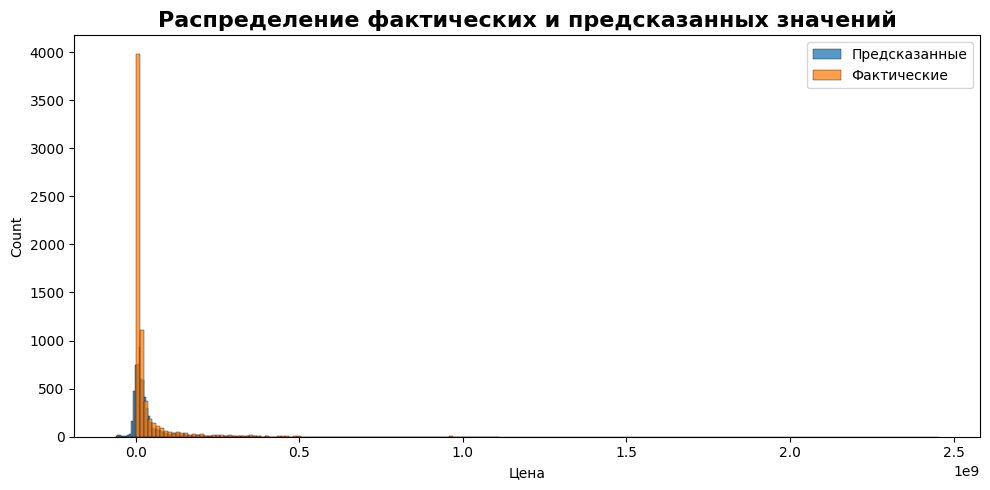

In [37]:
y_pred = ridge.predict(X_test)
plt.subplots(figsize = (10,5))
sns.histplot(y_pred, bins = 200, label = 'Предсказанные')
sns.histplot(y_test, bins = 200, label = 'Фактические')

plt.title('Распределение фактических и предсказанных значений')
plt.legend()
plt.tight_layout()
plt.savefig(save_fig('figures', 'Распределение факт и пред Ridge.png'))
plt.show()

In [38]:
# Тренировка на полном наборе данных
ridge = Ridge()
ridge.fit(X,y)

Ridge()

In [39]:
# Получение метрик из функции 
mape = metric(ridge, X, y)[0].mean()
mae = metric(ridge, X, y)[1].mean()
mse = metric(ridge, X, y)[2].mean()
rmse = np.sqrt(mse)

# Вывод метрик модели LR
print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 1.3000213422786635
MAE: 21983691.48256099
RMSE: 48770259.7799226


In [40]:
# Сохранение полного набора данных для Линейной регрессии
X['Цена'] = y

save_data(X, 'Данные для моделей', 'Данные для Ridge.csv')

### Занесем модель в MLFlow Tracking

In [41]:
# Загрузка метрик и модели в MLFlow
# ==============================================================================

mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,3)
rmse = round(rmse,3)
mape = round(mape,3)

signature = infer_signature(X_test, y_pred)

model_name = "Ridge"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логирование параметров
    mlflow.log_param("coef", ridge.coef_)
    mlflow.log_param("intercept", round(ridge.intercept_,2))

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)


    # Логирование датасета как артефакта
    mlflow.log_artifact(r"Данные для моделей/Данные для Ridge.csv", artifact_path='data')
    mlflow.log_artifact(r"figures/Распределение факт и пред Ridge.png", artifact_path='figures')
    
    # Запись модели
    mlflow.sklearn.log_model(ridge, "Redge_model", signature=signature)

## Тюнинг Ridge регрессии

Теперь подберем гиперпараметры с помощью GridSearch и попробоуем улучшить метрику MAE

In [42]:
X = X.drop('Цена', axis = 1)

In [43]:
# создаем модель Ridge
ridge = Ridge()

# Метрика MAE
mae = make_scorer(mean_absolute_error, greater_is_better=False)

param = {'alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]}
grid_search = GridSearchCV(ridge, param, scoring = mae, cv = 5)

# Выполним поиск по сетке
# ==============================================================================
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                   1.9, 2.0]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [44]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка MAE:", -grid_search.best_score_)

Лучшие параметры: {'alpha': 0.1}
Лучшая оценка MAE: 20857124.835189037


После подбора гиперпараметров на крос валидации, лучшим параметром оказалось значение `alpha` =  0.1
Натренируем модель с этим гиперпараметром и запишем ее в MLFlow Tracking

In [45]:
ridge_tun = Ridge(alpha = 0.1)

ridge_tun.fit(X, y)

# Получение метрик из функции 
mape = metric(ridge_tun, X, y)[0].mean()
mae = metric(ridge_tun, X, y)[1].mean()
mse = metric(ridge_tun, X, y)[2].mean()
rmse = np.sqrt(mse)

# Вывод метрик модели LR
print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 1.3000190253884936
MAE: 21983713.298226345
RMSE: 48770396.53360165


Модель стала лучше работать, чем Ridge без гиперпараметров, но все равно модель показывает плохие результаты, поэтому просто запишем ее в MLFlow Tracking и продолжим тестировать модели дальше 

In [46]:
# Сохранение полного набора данных для Линейной регрессии
X['Цена'] = y

save_data(X, 'Данные для моделей', 'Данные для Ridge_hyperparameters.csv')

### Записть Ridge hyperparameters в MLFlow

In [47]:
# Загрузка метрик и модели в MLFlow
# ==============================================================================

mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
rmse = round(rmse,2)
mape = round(mape,2)

signature = infer_signature(X_test, y_pred)

model_name = "Ridge_hyperparameters"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логирование параметров
    mlflow.log_param("coef", ridge_tun.coef_)
    mlflow.log_param("intercept", round(ridge_tun.intercept_,2))

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)


    # Логирование датасета как артефакта
    mlflow.log_artifact(r"Данные для моделей/Данные для Ridge_hyperparameters.csv", artifact_path='data')
    
    # Запись модели
    mlflow.sklearn.log_model(ridge_tun, "Redge_hyperparameters", signature=signature)

## RandomForest на числовых признаках

Это будет последняя модель, которую мы построим только на числовых признаках. Мы натренируем базовую модель случайного леса, после чего подберем гиперпараметры и всю информацию о моделях запишем в MLFlow Tracking, чтобы было после легко визуально сравнивать и оценивать производительность моделей. 

Данные будем использовать теже, что и при тренировки модели Ridge (то есть только числовые признаки)

In [48]:
X.drop('Цена', axis = 1, inplace = True)

In [49]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

### Оценка важности признаков модели RandomForest

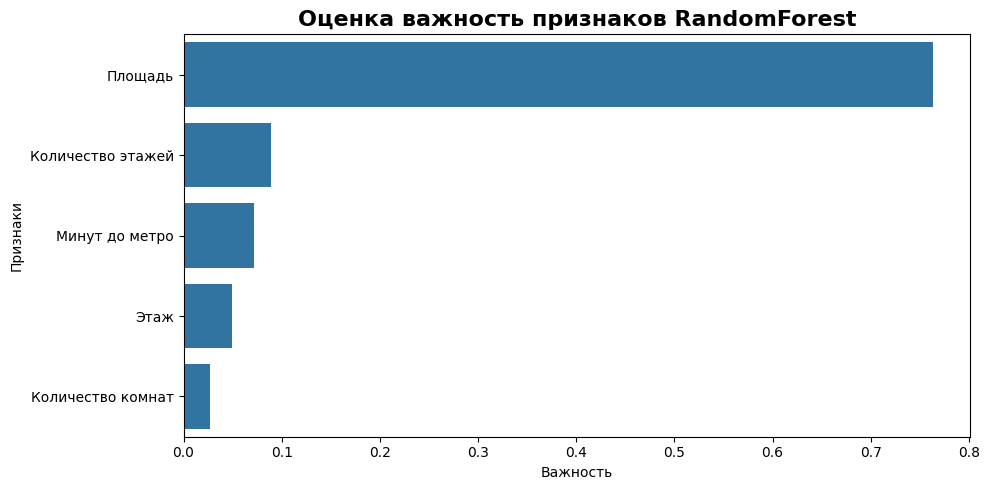

In [50]:
feature_importance = rf.feature_importances_
feature_names = X_train.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков RandomForest')
plt.savefig(save_fig('figures', "Оценка важность признаков RandomForest.png"))
plt.tight_layout()
plt.show()

Данный график показывает важность признаков, при тренировки модели `RandomForest`

**Выводы по важности признаков**
1. Самым важным признаком, при обучении модели - Площадь
2. Признаки (кроме площади) сильно отстают в важности, но все таки используются в модели, поэтому их следует оставить
3. Признак, который меньше всего использовался при разбиениях - `Количество комнат`

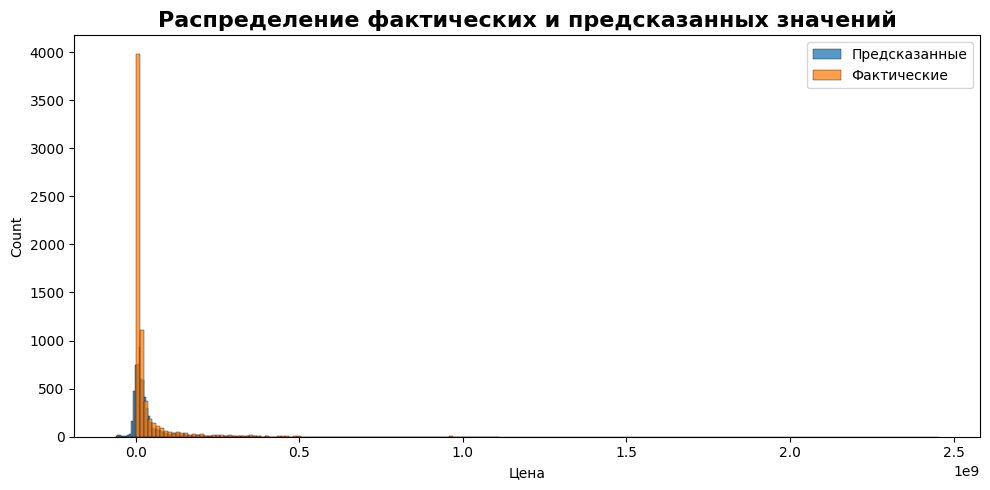

In [51]:
fig2 = plt.subplots(figsize = (10,5))
sns.histplot(y_pred, bins = 200, label = 'Предсказанные')
sns.histplot(y_test, bins = 200, label = 'Фактические')

plt.title('Распределение фактических и предсказанных значений')
plt.legend()
plt.tight_layout()
plt.savefig(save_fig('figures',"Распределение факт и пред RF.png"))
plt.show()

1. Данная модель обобщает большую чать дисперсии - 64%
2. Модель имеет ошибку всего в 0.19%, что является улучшением BaseLine
3. По графику видно, что плотности распределений предсказанных значений и фактических значений лучше совпадают, чем на предыдущих моделях

Запишем результаты работы модели в MLFlow Tracking

In [52]:
# Тренируем модель на полном наборе данных
rf = RandomForestRegressor()
rf.fit(X,y)

RandomForestRegressor()

In [53]:
# Получение метрик из функции 
mape = metric(rf, X, y)[0].mean()
mae = metric(rf, X, y)[1].mean()
mse = metric(rf, X, y)[2].mean()
rmse = np.sqrt(mse)

# Вывод метрик модели LR
print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 0.4500307080620562
MAE: 14239826.132860458
RMSE: 45655205.141911365


In [54]:
# Сохранение полного набора данных для Линейной регрессии
X['Цена'] = y

save_data(X, 'Данные для моделей', 'Данные для RandomForest_numeric.csv')

### Запись RandomForest в MLFlow Tracking

In [55]:
# Загрузка метрик и модели в MLFlow
# ==============================================================================
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
rmse = round(rmse,2)
mape = round(mape,2)

signature = infer_signature(X_test, y_pred)

model_name = "RandomForest_numeric"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)

    # Логирование датасета как артефакта
    mlflow.log_artifact(r"Данные для моделей/Данные для RandomForest_numeric.csv", artifact_path='data')
    mlflow.log_artifact(r"figures/Оценка важность признаков RandomForest.png", artifact_path='figures') 
    mlflow.log_artifact(r"figures/Распределение факт и пред RF.png", artifact_path='figures')
    
    # Запись модели
    mlflow.sklearn.log_model(rf, "RandomForest_numeric", signature=signature)

## RandomForest с категориальными признаками

После построения моделей только с числовыми признаками, добавим к нашим признакам еще и категориальные столбцы.

После добавления категориальных признаков - закодируем их и построим несколько моделей, которые работают с категориальными признаками.

In [56]:
X = df.copy()

# Создаем набор с категориальными переменными
X.drop(['Адрес', 'Ссылка', 'Цена'], axis = 1, inplace = True)
y = df['Цена']

In [57]:
cat = X.select_dtypes(include = ['object'])
cat.nunique()

Тип квартиры       2
Станция метро    310
Регион             2
Ремонт             4
dtype: int64

Здесь мы посмотрели количество уникальных значений в категориальных признаках. Больше всего униакальных значений в категории - `Станция метро`.

Просмотрим все уникальные значения в станции метро, если есть похожие станции, которые просто по разному написаны (например разница в регистре), то заменим эти значения, чтобы привести все к одному формату

Что касается другимх категориальных переменных:
1. Закодируем данные признаки - `Тип квартиры`, `Регион`, `Ремонт` с помощью OneHotEncoder, чтобы для каждого значения был создан свой столбец с бинарным значение.
2. После преобразования над столбцом `Станция метро` использвем кодирование LabelEbcoder чтобы избеджать слишком большого количества столбцов (так как с таким количеством столбцов уже будет неудобно работать)

### Закодируем Тип квартиры, Регион, Ремонт OneHotEncoder

In [58]:
# Столбцы которые будем кодировать
encoder = ['Тип квартиры', 'Регион', 'Ремонт']

# Кодируем каждый столбец
for e in encoder:
    X = pd.get_dummies(X, columns=[e])

# Вместо типа данных bool делаем 0 и 1
dummies = list(X.columns[7:])
X[dummies] = X[dummies].astype(int)
X.head(3)

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,опалиха,6.0,1.0,30.6,8.5,25.0,25,1,0,0,1,0,0,0,1
1,павшино,2.0,1.0,49.2,10.0,6.0,15,1,0,0,1,0,0,1,0
2,мякинино,14.0,1.0,44.7,13.1,10.0,25,1,0,0,1,0,0,0,1


In [59]:
X.dtypes

Станция метро                 object
Минут до метро               float64
Количество комнат            float64
Площадь                      float64
Кухня площадь                float64
Этаж                         float64
Количество этажей              int64
Тип квартиры_Вторичное         int64
Тип квартиры_Новостройка       int64
Регион_Москва                  int64
Регион_Московская область      int64
Ремонт_Без ремонта             int64
Ремонт_Дизайнерский            int64
Ремонт_Евроремонт              int64
Ремонт_Косметический           int64
dtype: object

Остался единственный категориальный столбец - `Станция метро`

Просмотрим уникальные значения и сделаем соответствуеющие преобразования

### Кодируем Станяию метро с помощью LabelEncoder

In [60]:
label_encoder = LabelEncoder()

# Кодируем
X['Станция метро'] = label_encoder.fit_transform(X['Станция метро'])

In [61]:
X.head()

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,173,6.0,1.0,30.6,8.5,25.0,25,1,0,0,1,0,0,0,1
1,180,2.0,1.0,49.2,10.0,6.0,15,1,0,0,1,0,0,1,0
2,145,14.0,1.0,44.7,13.1,10.0,25,1,0,0,1,0,0,0,1
3,244,8.0,1.0,35.1,11.0,12.0,33,1,0,0,1,0,0,1,0
4,173,6.0,1.0,37.7,4.0,5.0,5,1,0,0,1,1,0,0,0


In [62]:
X.dtypes

Станция метро                  int64
Минут до метро               float64
Количество комнат            float64
Площадь                      float64
Кухня площадь                float64
Этаж                         float64
Количество этажей              int64
Тип квартиры_Вторичное         int64
Тип квартиры_Новостройка       int64
Регион_Москва                  int64
Регион_Московская область      int64
Ремонт_Без ремонта             int64
Ремонт_Дизайнерский            int64
Ремонт_Евроремонт              int64
Ремонт_Косметический           int64
dtype: object

После всех преобразований у нас не осталось категориальных столбцов, а все категориальные значения преобразованы в цифры

Дальше можно тренировать модель **RandomForest** с добавленными категориальными признаками

In [63]:
# Модель для предсказания с категоримальными признаками
rf_cat = RandomForestRegressor()

# Тренировка модели на всем наборе данных
rf_cat.fit(X,y)

RandomForestRegressor()

In [64]:
m = metric(rf_cat, X, y)

In [67]:
# Получение метрик из функции 
mape = m[0].mean()
mae = m[1].mean()
mse = m[2].mean()
rmse = np.sqrt(mse)

# Вывод метрик модели LR
print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 0.25216183691108
MAE: 11673716.49408318
RMSE: 44713775.17995358


### Оценка вожности признаков модели

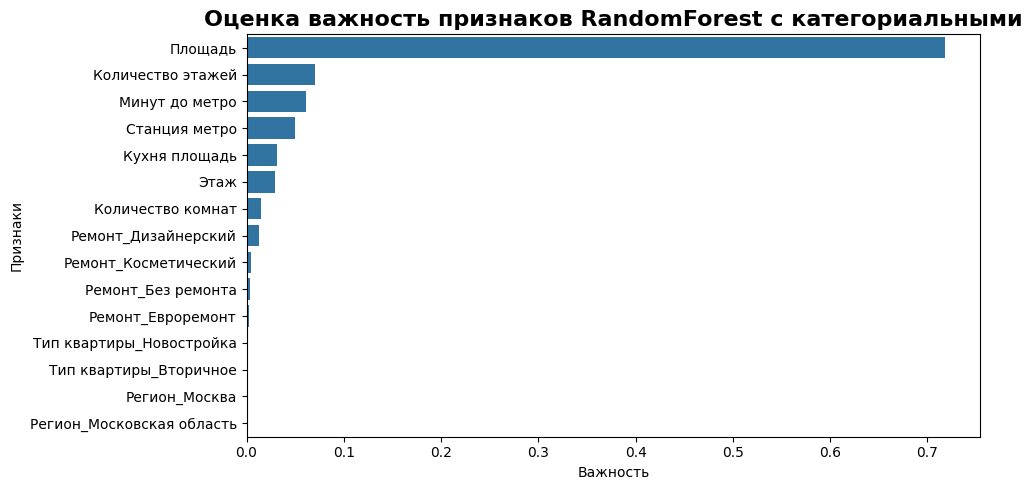

In [68]:
feature_importance = rf_cat.feature_importances_
feature_names = X.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков RandomForest с категориальными')
plt.savefig(save_fig('figures', "Оценка важность признаков RandomForest_cat.png"))
plt.tight_layout()
plt.show()

По факту категориаьлные значения никак не влияют на цену дома. Самым важным признаком оказался признак `Площадь`. Так же можно заметить что существенное влияние из категориальных признаков оказывает `Станция метро`

То есть можно сделать вывод, что для данной модели важны только числовые значения и станция метро. Так же на результат модели влияет `Тип ремонта` а именно дизайнерский и косметический ремонт, поэтому признак `Тип ремонта` тоже следует оставить для предсказания модели

### Сохраним данные для данной модели

In [69]:
# Сохранение полного набора данных для Линейной регрессии
X['Цена'] = y

save_data(X, 'Данные для моделей', 'Данные для RandomForest_category.csv')

### Загрузим RandomForest Category в MLFlow Tracking

In [70]:
# Загрузка метрик и модели в MLFlow
# ==============================================================================
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
rmse = round(rmse,2)
mape = round(mape,2)

signature = infer_signature(X, y)

model_name = "RandomForest_category"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)

    # Логирование датасета как артефакта
    mlflow.log_artifact(r"Данные для моделей/Данные для RandomForest_category.csv", artifact_path='data')
    mlflow.log_artifact(r"figures/Оценка важность признаков RandomForest_cat.png", artifact_path='figures')
    
    # Запись модели
    mlflow.sklearn.log_model(rf_cat, "RandomForest_category", signature=signature)

## CatBoost с категориальными переменными

### Создадим Pool для тренировки и отслеживания процесса обучения CatBoost

In [71]:
# Оставим только те данные которые будут использовать при обучении модели
X = df.copy()

# Предикторы 
X.drop(['Адрес', 'Ссылка', 'Цена'], axis = 1, inplace = True)
# Целевая переменная 
y = df['Цена']
# Категориальные переменные (создается специально для CatBoost)
category = list(X.select_dtypes(include = ['object']).columns)

# Разделим данные для отслеживания процесса обучения 
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size = 0.3, 
                                                  shuffle = True, 
                                                  random_state = 42)

train_pool = Pool(data = X_train, label = y_train, cat_features = category)
val_pool = Pool(data = X_val, label = y_val, cat_features = category)
full_pool = Pool(data = X, label = y, cat_features = category)

print('Train Pool\n', train_pool.shape)
print('\nValidation Pool\n', val_pool.shape)
print('\nFull Pool\n', full_pool.shape)

Train Pool
 (15269, 10)

Validation Pool
 (6544, 10)

Full Pool
 (21813, 10)


### Тренировка CatBoost без гиперпараметров

In [72]:
catboost = CatBoostRegressor(loss_function = 'MAPE')

catboost.fit(train_pool,
             eval_set = val_pool,
             verbose = 200,
             plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4889812	test: 0.4885503	best: 0.4885503 (0)	total: 71.6ms	remaining: 1m 11s
200:	learn: 0.3841561	test: 0.3824091	best: 0.3824091 (200)	total: 769ms	remaining: 3.06s
400:	learn: 0.3793272	test: 0.3776064	best: 0.3776064 (400)	total: 1.44s	remaining: 2.15s
600:	learn: 0.3792519	test: 0.3775430	best: 0.3775430 (600)	total: 1.99s	remaining: 1.32s
800:	learn: 0.3792283	test: 0.3775237	best: 0.3775237 (800)	total: 2.56s	remaining: 636ms
999:	learn: 0.3792172	test: 0.3775164	best: 0.3775164 (988)	total: 3.09s	remaining: 0us

bestTest = 0.3775163988
bestIteration = 988

Shrink model to first 989 iterations.


### Оценка модели с помощью кросс валидации (3 фолда)

In [73]:
params = {'loss_function' : 'MAPE'}
mape = cv(pool = full_pool,
          params = params,
          fold_count = 3, 
          plot = False,
          verbose = False)

params = {'loss_function' : 'MAE'}
mae = cv(pool = full_pool,
          params = params,
          fold_count = 3, 
          plot = False,
          verbose = False)

params = {'loss_function' : 'RMSE'}
rmse = cv(pool = full_pool,
          params = params,
          fold_count = 3, 
          plot = False,
          verbose = False)

Training on fold [0/3]

bestTest = 0.3345314586
bestIteration = 998

Training on fold [1/3]

bestTest = 0.3301036092
bestIteration = 999

Training on fold [2/3]

bestTest = 0.3387427922
bestIteration = 999

Training on fold [0/3]

bestTest = 9371408.382
bestIteration = 998

Training on fold [1/3]

bestTest = 8962297.022
bestIteration = 999

Training on fold [2/3]

bestTest = 10146717.6
bestIteration = 999

Training on fold [0/3]

bestTest = 38458530.04
bestIteration = 300

Training on fold [1/3]

bestTest = 37787859.93
bestIteration = 990

Training on fold [2/3]

bestTest = 39823435.66
bestIteration = 998



### Получение метрик для CatBoost

In [74]:
# Получите лучшие значения метрик

# Получение лучшей итерации 
best_iteration = mape['test-MAPE-mean'].idxmin()
# Получение лучшего значения 
best_mape = mape.loc[best_iteration, 'test-MAPE-mean']

mape = best_mape

# Получение лучшей итерации 
best_iteration = mae['test-MAE-mean'].idxmin()
# Получение лучшего значения 
best_mae = mae.loc[best_iteration, 'test-MAE-mean']

mae = best_mae

# Получение лучшей итерации 
best_iteration = rmse['test-RMSE-mean'].idxmin()
# Получение лучшего значения 
best_rmse = rmse.loc[best_iteration, 'test-RMSE-mean']

rmse = best_rmse

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 0.3344592879244175
MAE: 9493485.490189165
RMSE: 38970945.77949244


### Оценка важности признаков при обучении

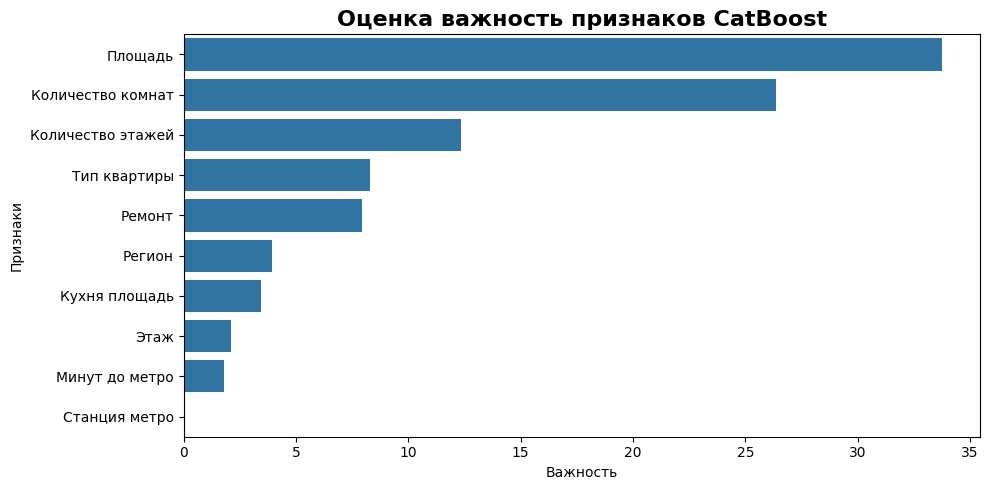

In [75]:
feature_importance = catboost.feature_importances_
feature_names = X.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков CatBoost')
plt.savefig(save_fig('figures', "Оценка важность признаков CatBoost.png"))
plt.tight_layout()
plt.show()

При использовании данной модели - признак `Станция метро` никак не повлиял на модель, то есть его в целом можно исключить из модели, но так же стоит заметить, что в отличие от других моделей - здесь почти все признаки имеют значение при обучении, и признак `Площадь` по прежнему остается самым значимым признаком для модели

### Запишем CatBoost в MLFlow Tracking

In [76]:
X['Цена'] = y
save_data(X, 'Данные для моделей', 'Данные для Catboost.csv')

In [77]:
params = {'loss_function' : 'MAPE'}

# Загрузка метрик и модели в MLFlow
# ==============================================================================
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
rmse = round(rmse,2)
mape = round(mape,2)

model_name = "CatBoost"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логируйте параметры модели
    mlflow.log_params(params)

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)

    # Логирование датасета как артефакта
    mlflow.log_artifact(r"Данные для моделей/Данные для Catboost.csv", artifact_path='data')
    mlflow.log_artifact(r"figures/Оценка важность признаков CatBoost.png", artifact_path='figures')
    
    # Запись модели
    mlflow.sklearn.log_model(catboost, "CatBoost")

## XGBoost с категориальными признаками

Так как XGBoost не работает с обработкой категориальных признаков, для начала закодируем категориальные значения, а после построим модель и оценим метрики с помощью кросс валиадции 

### Разделение данных на предикторы и целевую переменную

In [79]:
y = X['Цена']
X.drop('Цена', axis = 1, inplace = True)

### Обработка категориальных признаков

In [82]:
# Столбцы которые будем кодировать
encoder = ['Тип квартиры', 'Регион', 'Ремонт']

# Кодируем каждый столбец
for e in encoder:
    X = pd.get_dummies(X, columns=[e])

# Вместо типа данных bool делаем 0 и 1
dummies = list(X.columns[7:])
X[dummies] = X[dummies].astype(int)
X.head(3)

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,опалиха,6.0,1.0,30.6,8.5,25.0,25,1,0,0,1,0,0,0,1
1,павшино,2.0,1.0,49.2,10.0,6.0,15,1,0,0,1,0,0,1,0
2,мякинино,14.0,1.0,44.7,13.1,10.0,25,1,0,0,1,0,0,0,1


In [83]:
label_encoder = LabelEncoder()

# Кодируем
X['Станция метро'] = label_encoder.fit_transform(X['Станция метро'])

In [84]:
X.head(3)

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,173,6.0,1.0,30.6,8.5,25.0,25,1,0,0,1,0,0,0,1
1,180,2.0,1.0,49.2,10.0,6.0,15,1,0,0,1,0,0,1,0
2,145,14.0,1.0,44.7,13.1,10.0,25,1,0,0,1,0,0,0,1


### Тренировка модели XGBoost

In [91]:
xgb = XGBRegressor()

xgb.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Оценка модели на кросс валидации

In [92]:
# Получение метрик из функции 
mape = metric(xgb, X, y)[0].mean()
mae = metric(xgb, X, y)[1].mean()
mse = metric(xgb, X, y)[2].mean()
rmse = np.sqrt(mse)

# Вывод метрик модели LR
print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 0.2723028251354675
MAE: 11695243.903586201
RMSE: 45944570.66975276


### Оценка важности признаков

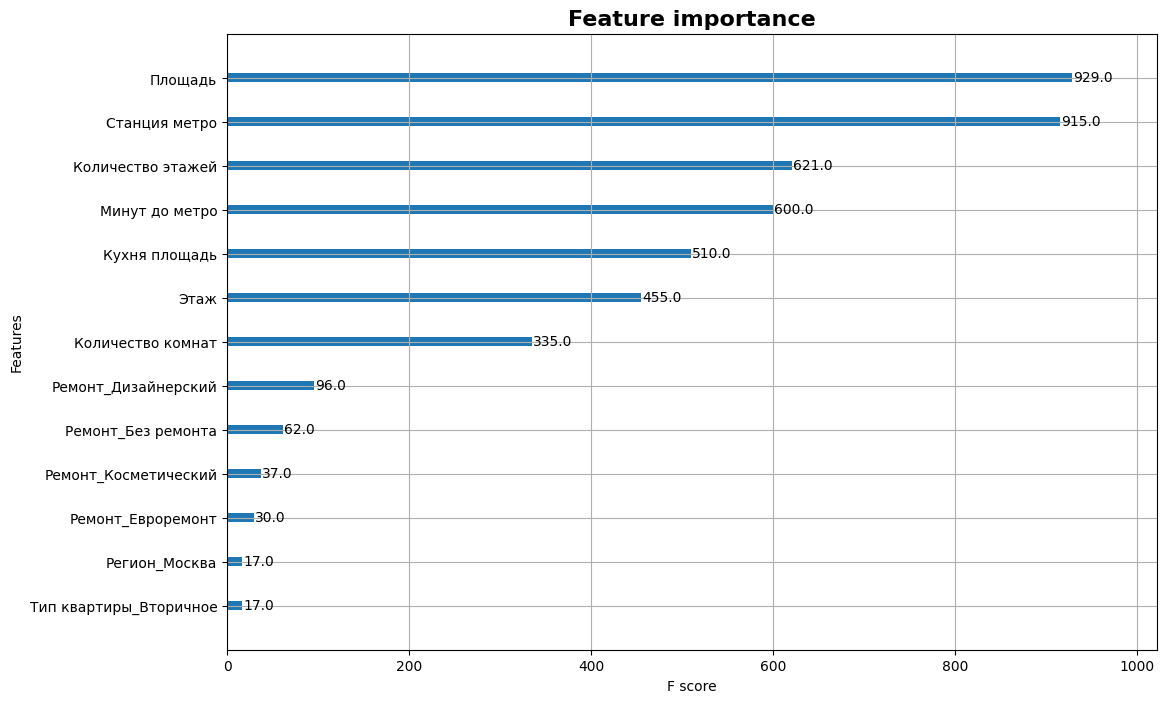

In [97]:
plot_importance(xgb)
plt.savefig(save_fig('figures', "Оценка важность признаков XGBoost.png"))
plt.show()

### Сохраняем набора данных для XGBoost

In [99]:
X['Цена'] = y
save_data(X, 'Данные для моделей', 'Данные для XGBoost.csv')

### Сохраняем модель XGBoost в MLFlow Tracking

In [101]:
params = xgb.get_params()

# Загрузка метрик и модели в MLFlow
# ==============================================================================
mlflow.set_tracking_uri(uri = "http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
rmse = round(rmse,2)
mape = round(mape,2)

model_name = 'XGBoost'
with mlflow.start_run(run_name = model_name) as run:

    # Логируйте параметры модели
    mlflow.log_params(params)

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)

    # Логирование датасета как артефакта
    mlflow.log_artifact(r"Данные для моделей/Данные для XGBoost.csv", artifact_path='data')
    mlflow.log_artifact(r"figures/Оценка важность признаков XGBoost.png", artifact_path='figures')

    # Запись модели
    mlflow.sklearn.log_model(xgb, "XGBoost")

## Вывод по работам моделей

In [113]:
# Получим таблицу метрик всех выполненных моделей
experiment_name = "House_price_predictions"

# Вывод метрик для всех моделей
runs = mlflow.search_runs(experiment_ids=mlflow.get_experiment_by_name(experiment_name).experiment_id)
runs = runs[['tags.mlflow.runName', 'metrics.mape', 'metrics.rmse', 'metrics.mae']]
runs['metrics.rmse'] = runs['metrics.rmse'].apply(lambda x: '{:.3f}'.format(x))
runs['metrics.mae'] = runs['metrics.mae'].apply(lambda x: '{:.3f}'.format(x))
runs.index = runs['tags.mlflow.runName']
runs.index.name = None
runs.drop('tags.mlflow.runName', axis = 1, inplace = True)
runs.columns = [['MAPE', 'RMSE', 'MAE']]

# Выгрузка метрик в виде таблицы для каждой модели
# ==============================================================================
runs

,MAPE,RMSE,MAE
XGBoost,0.270,45944570.670,11695243.900
CatBoost,0.330,38970945.780,9493485.490
RandomForest_category,0.250,44713775.180,11673716.490
RandomForest_numeric,0.450,45655205.140,14239826.130
Ridge_hyperparameters,1.300,48770396.530,21983713.300
Ridge,1.300,48770259.780,21983691.483
Linear_Regression,1.227,48600889.377,21055504.792


1. Как видно из данной таблицы - мы натренировали 7 моделей, как линейные, так и нелинейные модели
2. Данная таблица не осторитиваана по метрикам, а значения располагают по новизне (то есть модели которые тренировались последними, располагаются на первых строках)
3. Визуальные оценки метрик (гистограммы) находятся на локальном сервере в MLFlow

Как видно из таблицы - самая лучшая метрика MAE у модели CatBoost

Далее мы заменим выбросы на более приближенные значения в наборе данных и натренируем заново все модели без выбросов

## Замена выбросов в наборе данных

Сначала построим матрицу boxplot чтобы понять в каких признаках суествую выбросы 

### Матрица для определения выбросов 

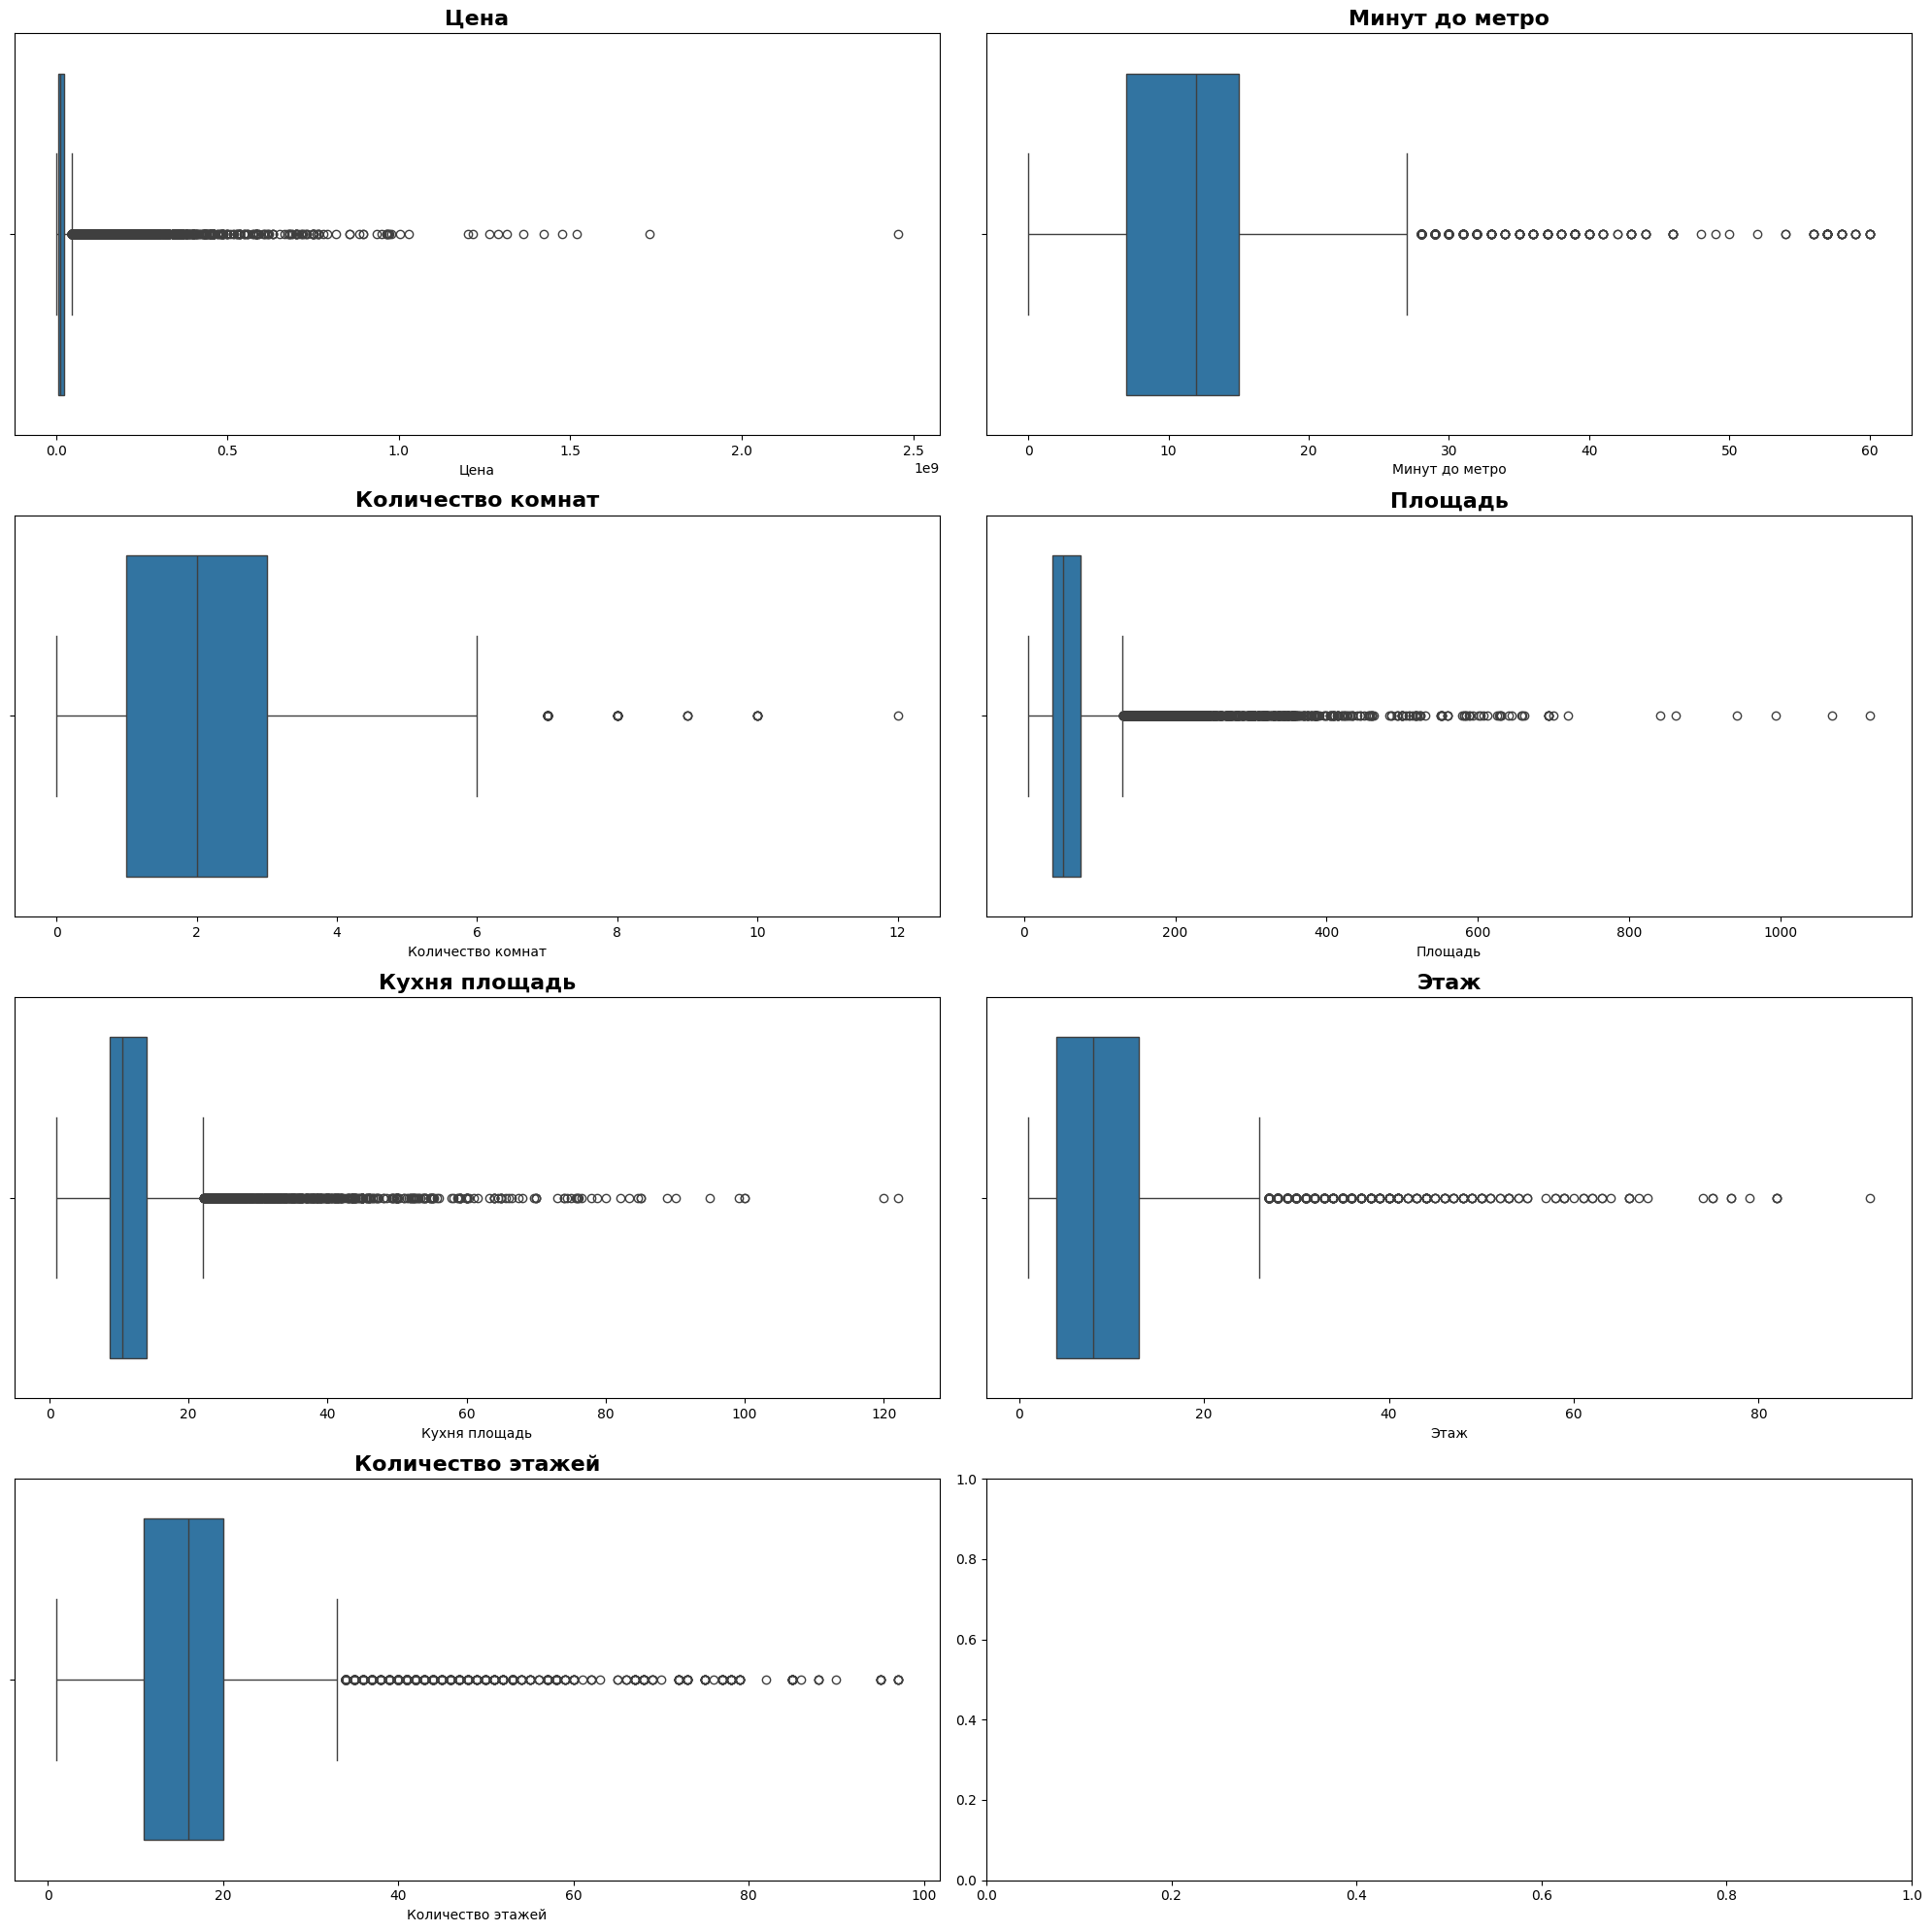

In [218]:
numeric_lst = list(df.select_dtypes(include = ['float64', 'int64']).columns)

fig, axes = plt.subplots(4,2, figsize = (20,20))

for i, n in enumerate(numeric_lst):
    ax = axes[i // 2,i % 2]
    sns.boxplot(data = df,
                x = n,
                ax = ax)
    ax.set_title(n)

plt.tight_layout()
plt.show()

Так как нам нужна модель, которая обучена на большинсве средних значений - следовательно выбросы что с целевой переменной что в объясняющиъ переменных нам надо заменить на средние значения этих переменных

Заменять выбросы будем, чтобы не потерять информацию, потому что у нас и так не так много наблюдений, а если удалить, то останется еще меньше, поэтому выбираем метод замены выбросов

Заменять будем на среднее значение, а выбросы будем искать с помощью IQR метода 

Во всех признаках заменим значения, кроме `Количество комнат` 

In [219]:
# Создаем список со значениями, где надо заменить выбросы 
emissions = df.select_dtypes(include = ['float64', 'int64'])
emissions.drop('Количество комнат', axis = 1, inplace = True)
emissions_lst = list(emissions.columns)
emissions_lst

['Цена',
 'Минут до метро',
 'Площадь',
 'Кухня площадь',
 'Этаж',
 'Количество этажей']

### Функция которая заменяет выбросы в признаках (IQR)

In [220]:
X = df[['Цена', 'Тип квартиры', 'Станция метро', 'Минут до метро', 'Регион',
        'Количество комнат', 'Площадь', 'Кухня площадь', 'Этаж', 'Количество этажей', 'Ремонт']]
X.head(3)

,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Ремонт
0,6300000.0,Вторичное,опалиха,6.0,Московская область,1.0,30.6,8.5,25.0,25,Косметический
1,9000000.0,Вторичное,павшино,2.0,Московская область,1.0,49.2,10.0,6.0,15,Евроремонт
2,11090000.0,Вторичное,мякинино,14.0,Московская область,1.0,44.7,13.1,10.0,25,Косметический


In [221]:
def iqr_replacement(data, list_replace):
    """
    data: набор данных для применения замены выбросов
    list_replace: список признаков, в которых заменить выбросы
    """
    # Замена выбросов на медианное значение
    for l in list_replace:
        q1 = data[l].quantile(0.25)
        q3 = data[l].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        data[l] = data[l].apply(lambda x: data[l].median() if x < lower_bound or x > upper_bound else x)

    return data

In [222]:
X = iqr_replacement(X, emissions_lst)
X.head(3)

,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Ремонт
0,6300000.0,Вторичное,опалиха,6.0,Московская область,1.0,30.6,8.5,25.0,25.0,Косметический
1,9000000.0,Вторичное,павшино,2.0,Московская область,1.0,49.2,10.0,6.0,15.0,Евроремонт
2,11090000.0,Вторичное,мякинино,14.0,Московская область,1.0,44.7,13.1,10.0,25.0,Косметический


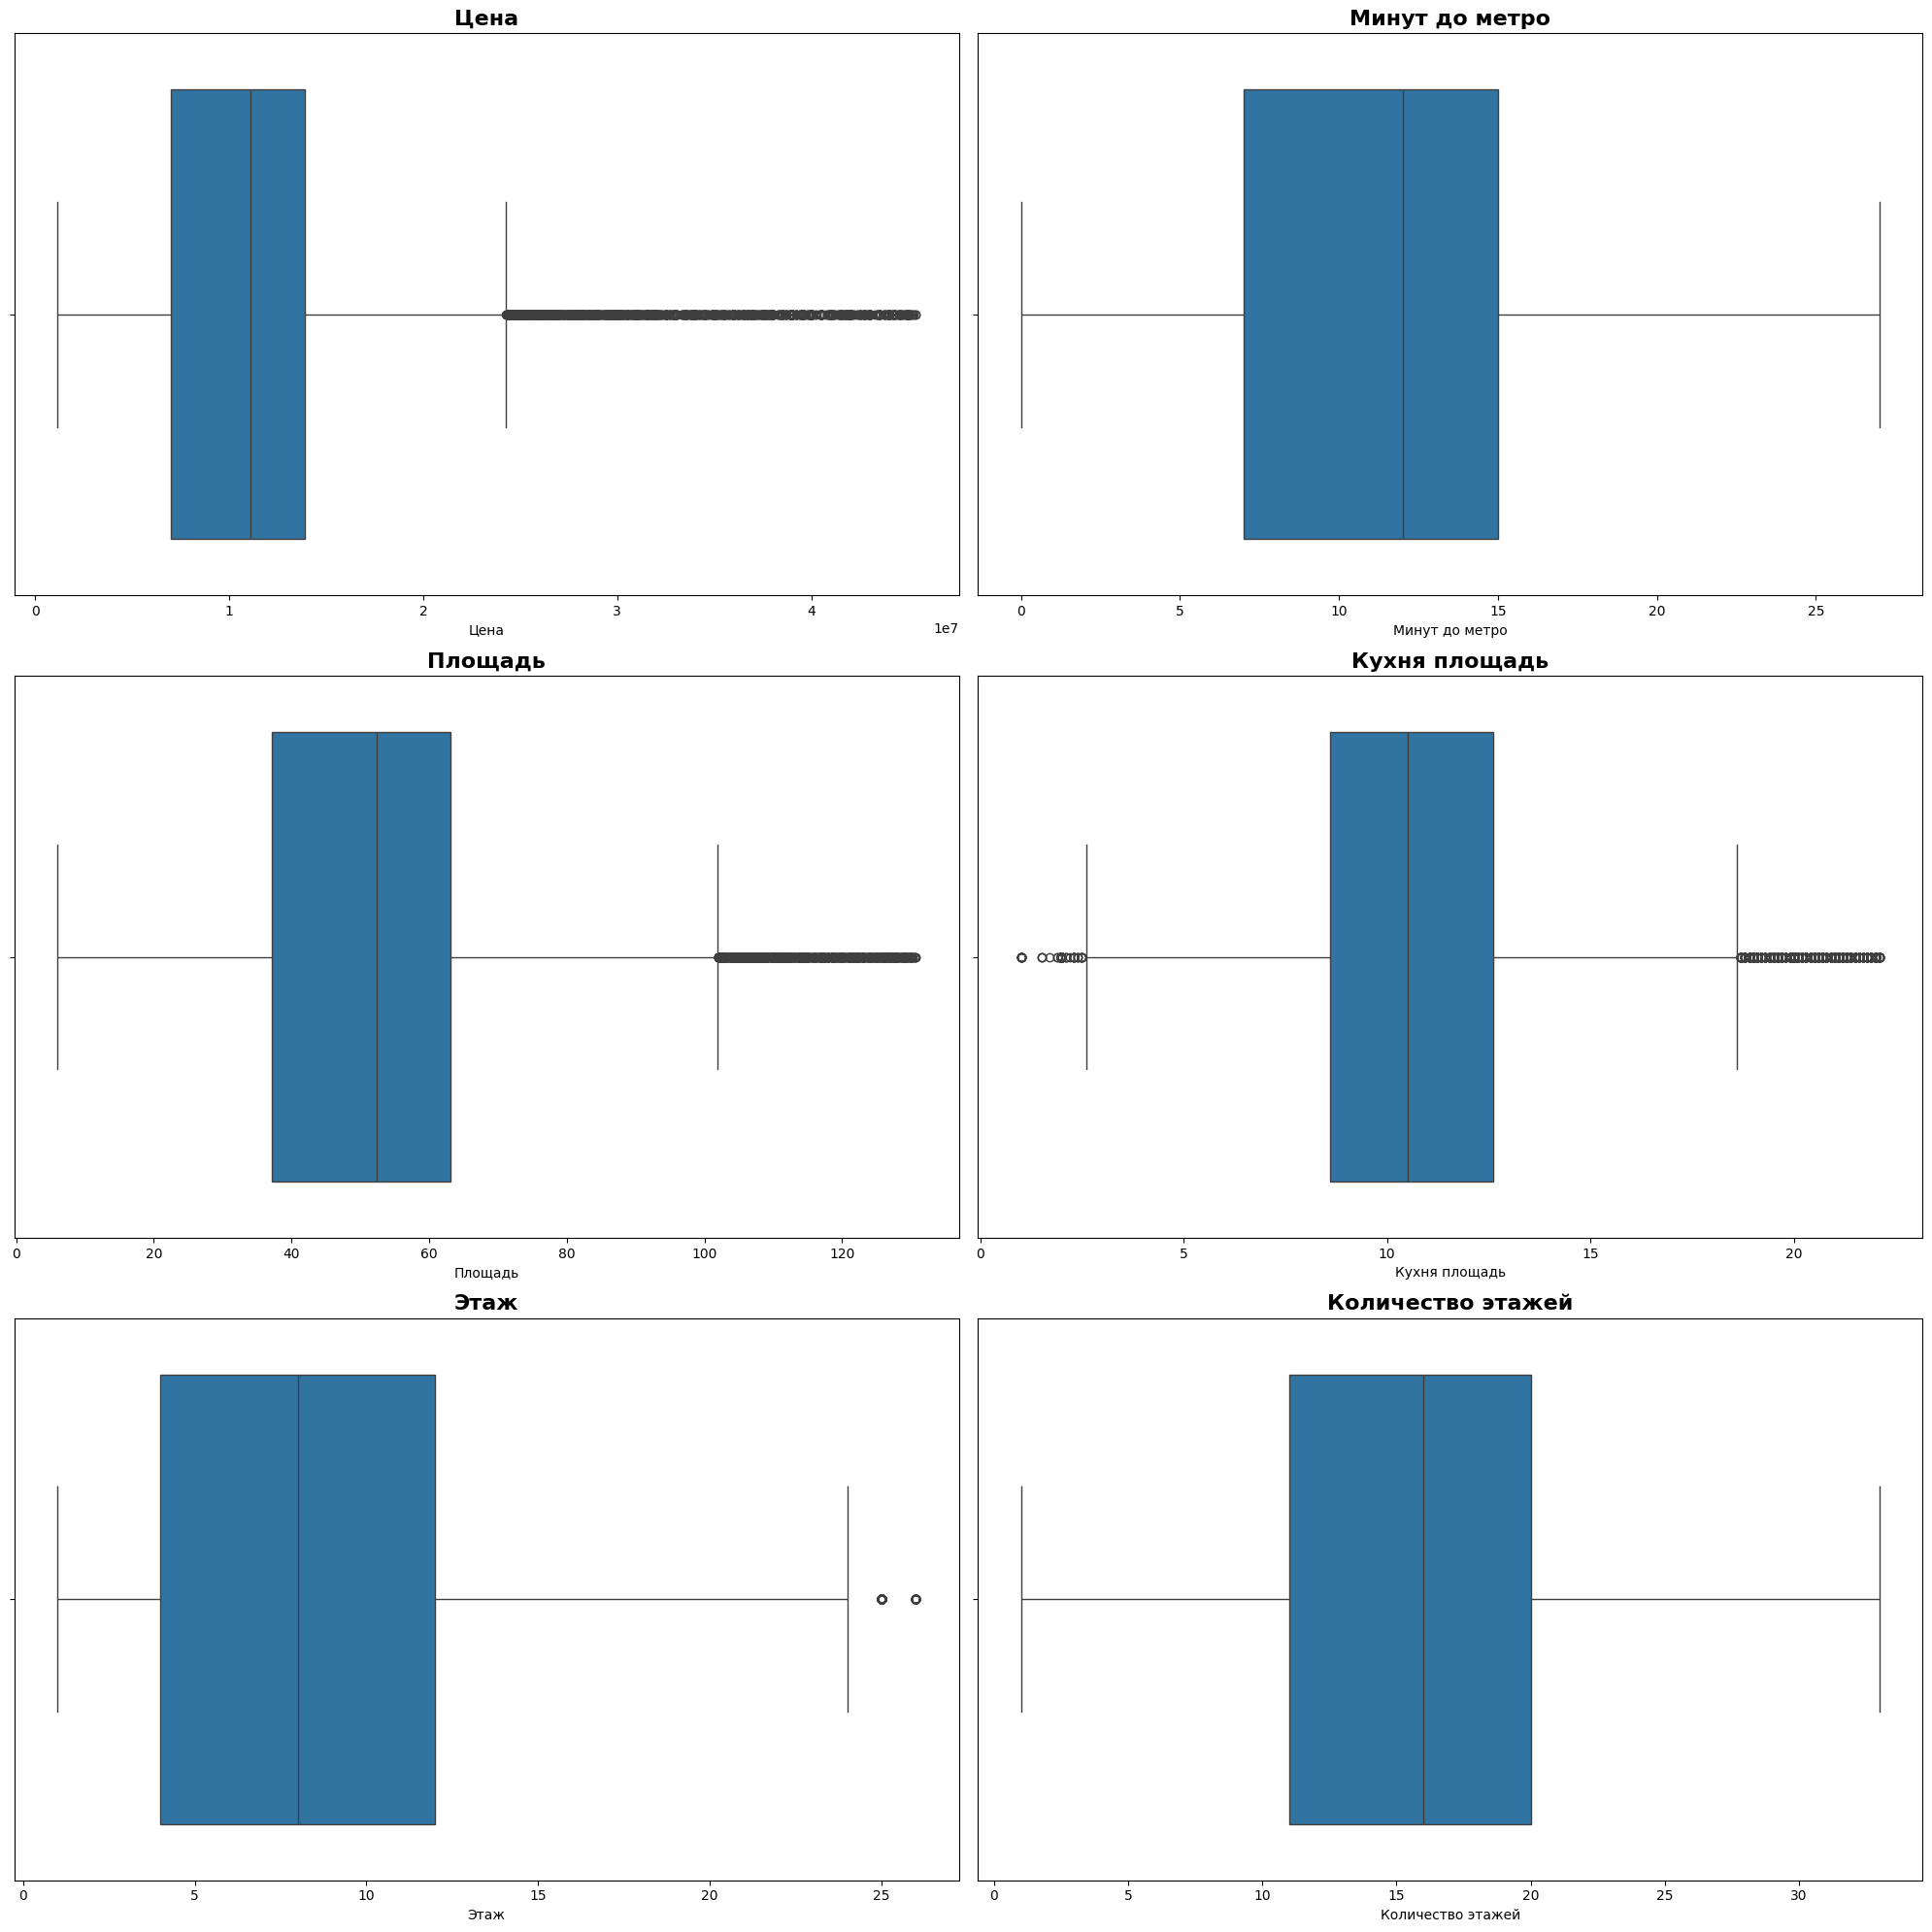

In [223]:
fig, axes = plt.subplots(3,2, figsize = (20,20))

for i, n in enumerate(emissions_lst):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data = X,
                x = n,
                ax = ax)
    ax.set_title(n)

plt.tight_layout()
plt.show()

После выполнения функции к набору данных **X** мы получили новые распределения в данных. Их можно сравнить с предыдущей визуализацией и увидеть, что сейчас стало меньше выбросов в данных (то есть меньше экстремальных значений), а соответственно и сами данные стали распределяться в основном вокруг медианного значения, что поможет модели больше ориентироваться на средние значения

Далее мы построим все модели, которые мы строили с категориальными данные (сделал вывод о том, что модели, которые работают только с числовыми признаками плохо справляются с предсказательной способностью (из за высокой ошибки и других метрик)), поэтому будут перетренированы модели, которые работают с категориальными признаками, занесены в MLFlow для сравнения метрик и выбрана лучшая модель, которая будет использована непосредствнно в проекте бота

**Перетренировывать будем следующие модели:**
1. RandomForest
2. CatBoost
3. XGBoost

# Тренировка моделей с данными, где были заменены выбросы

In [224]:
# Данные где заменены выбросы
data = X.copy()
data.head(3)

,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Ремонт
0,6300000.0,Вторичное,опалиха,6.0,Московская область,1.0,30.6,8.5,25.0,25.0,Косметический
1,9000000.0,Вторичное,павшино,2.0,Московская область,1.0,49.2,10.0,6.0,15.0,Евроремонт
2,11090000.0,Вторичное,мякинино,14.0,Московская область,1.0,44.7,13.1,10.0,25.0,Косметический


## Тренировка RandomForest

In [228]:
# Данные для обучения 
y = data['Цена']
X = data.drop('Цена', axis = 1)

### Закодируем категориальные признаки

In [229]:
# Столбцы которые будем кодировать
encoder = ['Тип квартиры', 'Регион', 'Ремонт']

# Кодируем каждый столбец
for e in encoder:
    X = pd.get_dummies(X, columns=[e])

# Вместо типа данных bool делаем 0 и 1
dummies = list(X.columns[7:])
X[dummies] = X[dummies].astype(int)
X.head(3)

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,опалиха,6.0,1.0,30.6,8.5,25.0,25.0,1,0,0,1,0,0,0,1
1,павшино,2.0,1.0,49.2,10.0,6.0,15.0,1,0,0,1,0,0,1,0
2,мякинино,14.0,1.0,44.7,13.1,10.0,25.0,1,0,0,1,0,0,0,1


In [230]:
label_encoder = LabelEncoder()

# Кодируем
X['Станция метро'] = label_encoder.fit_transform(X['Станция метро'])

In [231]:
X.head(3)

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,173,6.0,1.0,30.6,8.5,25.0,25.0,1,0,0,1,0,0,0,1
1,180,2.0,1.0,49.2,10.0,6.0,15.0,1,0,0,1,0,0,1,0
2,145,14.0,1.0,44.7,13.1,10.0,25.0,1,0,0,1,0,0,0,1


### Тренируем модель

In [234]:
# Модель для предсказания с категоримальными признаками
rf_cat = RandomForestRegressor()

# Тренировка модели на всем наборе данных
rf_cat.fit(X,y)

RandomForestRegressor()

In [235]:
m = metric(rf_cat, X, y)

In [236]:
# Получение метрик из функции 
mape = m[0].mean()
mae = m[1].mean()
mse = m[2].mean()
rmse = np.sqrt(mse)

# Вывод метрик модели LR
print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 0.20084819627359804
MAE: 2736280.9943432757
RMSE: 5054732.880112151


### Оценка важности признаков при тренировке

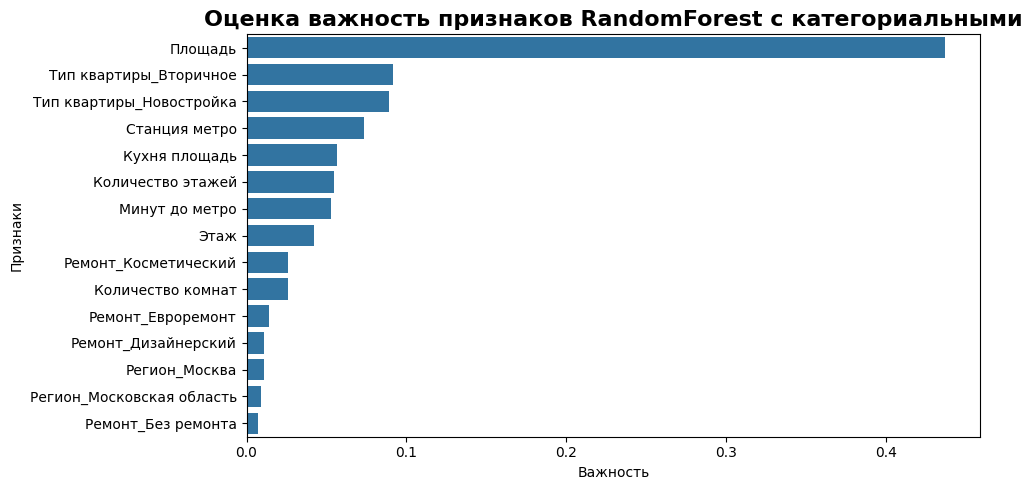

In [237]:
feature_importance = rf_cat.feature_importances_
feature_names = X.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков RandomForest с категориальными')
plt.savefig(save_fig('figures', "Оценка важность признаков RandomForest_cat.png"))
plt.tight_layout()
plt.show()

### Запись RandomForest в MLFlow Traking

In [239]:
X['Цена'] = y
save_data(X, 'Данные для моделей', 'Данные для RandomForest без выбросов.csv')

In [240]:
# Загрузка метрик и модели в MLFlow
# ==============================================================================
mlflow.set_tracking_uri(uri = "http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
rmse = round(rmse,2)
mape = round(mape,2)

model_name = 'RF_no_emissions'
with mlflow.start_run(run_name = model_name) as run:

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)

    # Логирование датасета как артефакта
    mlflow.log_artifact(r"Данные для моделей/Данные для RandomForest без выбросов.csv", artifact_path='data')
    mlflow.log_artifact(r"figures/Оценка важность признаков RandomForest_cat.png", artifact_path='figures')

    # Запись модели
    mlflow.sklearn.log_model(rf_cat, "RF_no_emissions")

## Тренировка XGBoost

После тренировки RandomForest у нас остались закодированные данные, поэтому используем их для перетренировки модели XGBoost

In [243]:
X.head(3)

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический,Цена
0,173,6.0,1.0,30.6,8.5,25.0,25.0,1,0,0,1,0,0,0,1,6300000.0
1,180,2.0,1.0,49.2,10.0,6.0,15.0,1,0,0,1,0,0,1,0,9000000.0
2,145,14.0,1.0,44.7,13.1,10.0,25.0,1,0,0,1,0,0,0,1,11090000.0


In [244]:
# Разделим данные на целевую переменную и признаки 
y = X['Цена']
X.drop('Цена', axis = 1, inplace = True)

In [246]:
# Тренировка модели
xgb = XGBRegressor()

xgb.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Получение метрик для модели 

In [247]:
# Получение метрик из функции 
mape = metric(xgb, X, y)[0].mean()
mae = metric(xgb, X, y)[1].mean()
mse = metric(xgb, X, y)[2].mean()
rmse = np.sqrt(mse)

# Вывод метрик модели LR
print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 0.21675563545819956
MAE: 2881010.9856600706
RMSE: 5230814.99796651


### Оценка важности переменных пр обучении

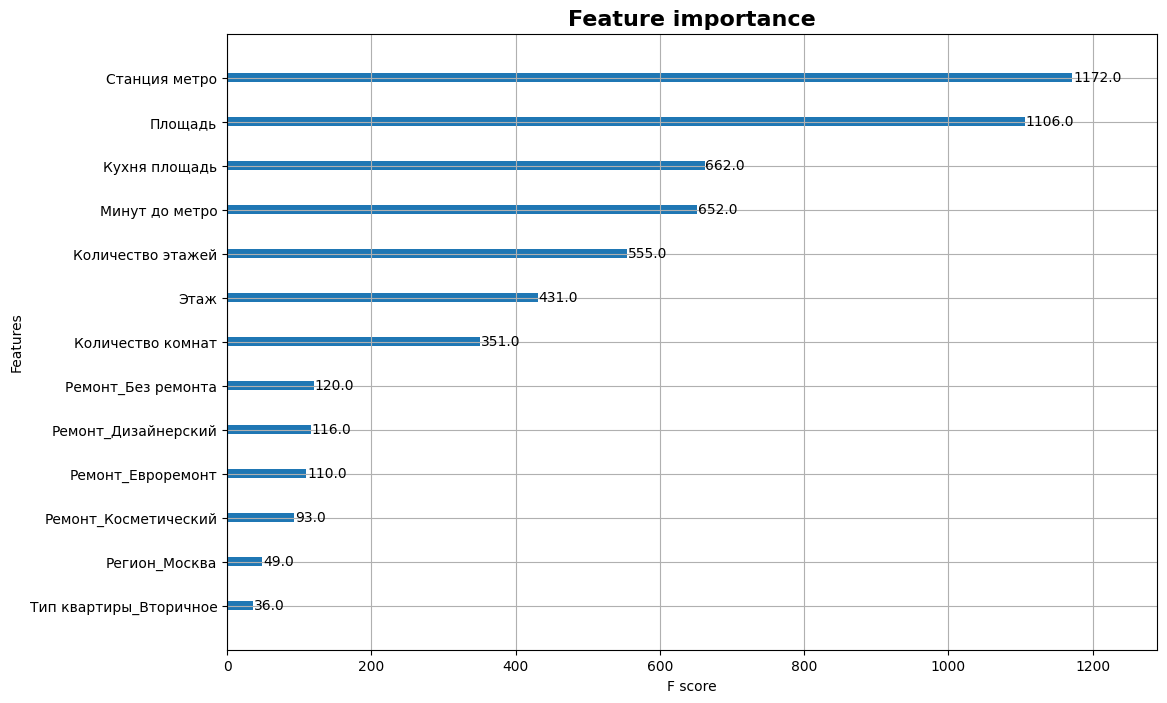

In [248]:
plot_importance(xgb)
plt.savefig(save_fig('figures', "Оценка важность признаков XGBoost без выбросов.png"))
plt.show()

### Сохраняем данные для модели

In [249]:
X['Цена'] = y
save_data(X, 'Данные для моделей', 'Данные для XGBoost без выбросов.csv')

### Сохраняем XGBoost в MLFlow Tracking

In [250]:
params = xgb.get_params()

# Загрузка метрик и модели в MLFlow
# ==============================================================================
mlflow.set_tracking_uri(uri = "http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
rmse = round(rmse,2)
mape = round(mape,2)

model_name = 'XGBoost_no_emissions'
with mlflow.start_run(run_name = model_name) as run:

    # Логируйте параметры модели
    mlflow.log_params(params)

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)

    # Логирование датасета как артефакта
    mlflow.log_artifact(r"Данные для моделей/Данные для XGBoost без выбросов.csv", artifact_path='data')
    mlflow.log_artifact(r"figures/Оценка важность признаков XGBoost без выбросов.png", artifact_path='figures')

    # Запись модели
    mlflow.sklearn.log_model(xgb, "XGBoost_no_emissions")

## Тренировка CatBoost

Так как X - у нас данные которые закодированы (а CatBoost как известно хорошо работает с категориальными данными) то возьмем и перетренируем на наборе данных data, где как раз и нет никаких преобразований с категориальными данными

In [254]:
# Данные которые будем использовать для тренировки модели
data.head(3)

,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Ремонт
0,6300000.0,Вторичное,опалиха,6.0,Московская область,1.0,30.6,8.5,25.0,25.0,Косметический
1,9000000.0,Вторичное,павшино,2.0,Московская область,1.0,49.2,10.0,6.0,15.0,Евроремонт
2,11090000.0,Вторичное,мякинино,14.0,Московская область,1.0,44.7,13.1,10.0,25.0,Косметический


### Создадим Pool для тренировки моделей

In [263]:
y = data['Цена']
X = data.drop('Цена', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    shuffle = True, 
                                                    random_state = 42)
# Список категориальных столцов (только для CatBoost)
category = list(data.select_dtypes(include = 'object').columns)

train_pool = Pool(data = X_train, label = y_train, cat_features = category)
val_pool = Pool(data = X_test, label = y_test, cat_features = category)
full_pool = Pool(data = X, label = y, cat_features = category)

print('Training Pool\n', train_pool.shape)
print('\nValidation Pool\n', val_pool.shape)
print('\nFull Pool\n', full_pool.shape)

Training Pool
 (15269, 10)

Validation Pool
 (6544, 10)

Full Pool
 (21813, 10)


### Обучим модель CatBoost

In [309]:
params = {'loss_function' : 'MAE',
          "learning_rate" : 0.1}

mae = cv(pool = full_pool,
         params = params,
         fold_count = 3,
         plot = False,
         verbose = 499)


params = {'loss_function' : 'MAPE',
         "learning_rate" : 0.1}

mape = cv(pool = full_pool,
          params = params,
          fold_count = 3, 
          plot = False,
          verbose = 499)


params = {'loss_function' : 'RMSE',
         "learning_rate" : 0.1}

rmse = cv(pool = full_pool,
          params = params,
          fold_count = 3, 
          plot = False,
          verbose = 499)

Training on fold [0/3]
0:	learn: 11152659.5262957	test: 11246810.4624511	best: 11246810.4624511 (0)	total: 6.49ms	remaining: 6.48s
499:	learn: 1805531.6605478	test: 2059561.0042923	best: 2059561.0042923 (499)	total: 2.27s	remaining: 2.27s
998:	learn: 1651190.6082133	test: 2007358.6590999	best: 2007159.4210369 (988)	total: 6.52s	remaining: 6.53ms
999:	learn: 1651111.9124436	test: 2007287.4407132	best: 2007159.4210369 (988)	total: 6.53s	remaining: 0us

bestTest = 2007159.421
bestIteration = 988

Training on fold [1/3]
0:	learn: 11187759.7614366	test: 11190461.9301148	best: 11190461.9301148 (0)	total: 13.1ms	remaining: 13s
499:	learn: 1860338.9045656	test: 1979933.5411261	best: 1979859.6467210 (497)	total: 6.72s	remaining: 6.72s
998:	learn: 1690018.4211886	test: 1941429.4128673	best: 1941429.4128673 (998)	total: 13.7s	remaining: 13.8ms
999:	learn: 1689802.8997515	test: 1941331.6461983	best: 1941331.6461983 (999)	total: 13.8s	remaining: 0us

bestTest = 1941331.646
bestIteration = 999

Trai

In [310]:
# Получите лучшие значения метрик

# Получение лучшей итерации 
best_iteration = mape['test-MAPE-mean'].idxmin()
# Получение лучшего значения 
best_mape = mape.loc[best_iteration, 'test-MAPE-mean']

mape = best_mape

# Получение лучшей итерации 
best_iteration = mae['test-MAE-mean'].idxmin()
# Получение лучшего значения 
best_mae = mae.loc[best_iteration, 'test-MAE-mean']

mae = best_mae

# Получение лучшей итерации 
best_iteration = rmse['test-RMSE-mean'].idxmin()
# Получение лучшего значения 
best_rmse = rmse.loc[best_iteration, 'test-RMSE-mean']

rmse = best_rmse

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 0.2331107146237564
MAE: 1975044.4914291364
RMSE: 4193612.2017428665


### Оценка важности признаков 

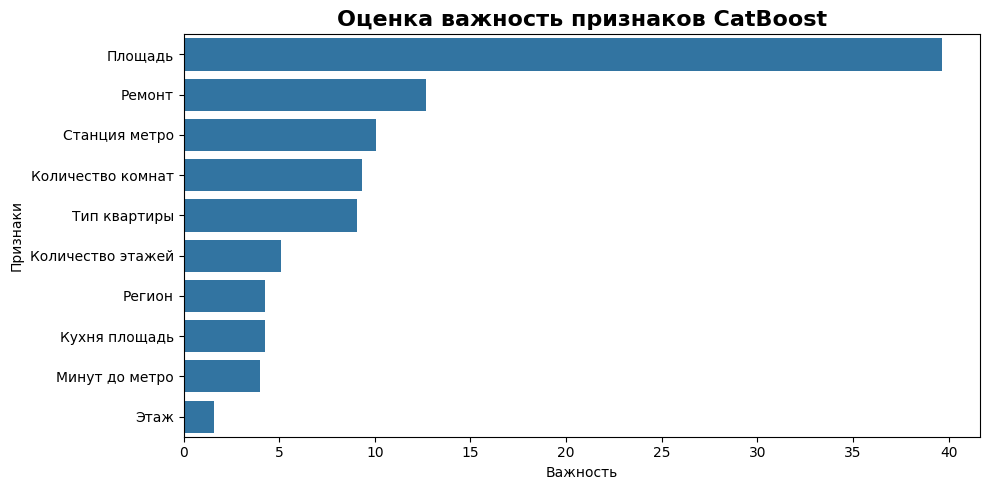

In [311]:
feature_importance = catboost.feature_importances_
feature_names = X.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков CatBoost')
plt.savefig(save_fig('figures', "Оценка важность признаков CatBoost без выбросов.png"))
plt.tight_layout()
plt.show()

### Запись CatBoost в  MLFlow Tracking

In [317]:
catboost = CatBoostRegressor(loss_function = 'MAE',
                             learning_rate = 0.1)
catboost.fit(full_pool,
             verbose = False,
             plot = False)

In [318]:
X['Цена'] = y
save_data(X, 'Данные для моделей', 'Данные для Catboost без выбросов.csv')

In [319]:
params = {'loss_function' : 'MAE',
          "learning_rate" : 0.1}

# Загрузка метрик и модели в MLFlow
# ==============================================================================
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
rmse = round(rmse,2)
mape = round(mape,2)

model_name = "CatBoost_no_emissions"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логируйте параметры модели
    mlflow.log_params(params)

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)

    # Логирование датасета как артефакта
    mlflow.log_artifact(r"Данные для моделей/Данные для Catboost без выбросов.csv", artifact_path='data')
    mlflow.log_artifact(r"figures/Оценка важность признаков CatBoost без выбросов.png", artifact_path='figures')
    
    # Запись модели
    mlflow.sklearn.log_model(catboost, "CatBoost_no_emissions")

# Сохранение модели для Продакшена

In [320]:
import pickle

model_filename = 'CatBoostRegressor.pkl'

# Сохранение модели в формате Pickle
with open(model_filename, 'wb') as model_file:
    pickle.dump(catboost, model_file)